In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

## Project objective
- Predict probability of default

In [1494]:
data = pd.read_csv('accepted_2007_to_2018Q4.csv')

### Exploratory data analysis

In [1495]:
# Huge dataset. 151 fields.
data.shape

(2260701, 151)

In [1496]:
# Due to the size of data, firstly select records needed for modeling
# The target variable is default, which can be determined using loan_status field
# Take a look at the types of loan status
print(data['loan_status'].unique())

['Fully Paid' 'Current' 'Charged Off' 'In Grace Period'
 'Late (31-120 days)' 'Late (16-30 days)' 'Default' nan
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']


In [1497]:
# Since the objective is to predict if a borrower will repay the loan or default, only need to select a few types of loan status:
# Fully Paid, Charged Off, Default
# Late (31-120 days) can also be considered default, but for this analysis, let's not consider it as default
data = data[data['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]

In [1498]:
# Add a column default used as target variable
# 1 when a borrower defaults, 0 when a borrower repays the loan
data['default'] = np.where(data['loan_status']=='Fully Paid', 0, 1)

In [1499]:
# Drop loan_status
data.drop(columns='loan_status', inplace=True)

#### 1st: Remove ineffective and highly correlated features
- Since there are almost 150 features in the dataset, it would be time-consuming to examine the importance of each feature. Start with removing ineffective and highly correlated features. This helps save time on selecting features with the best discriminant power and reduce multicollinearity in the model. 
- When the correlation between two features >= 0.7, they are considered highly correlated, so one needs to be removed.

##### Remove ineffective features
There are two types of ineffective features:

1. Features that don't add any predicting power, such as id of the loan and member id of the borrower.
2. Features that can't be measured before the outcome occurs, such as funded amount and total payment recevied.

In [9]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,default
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [1500]:
# pymnt_plan only contains 1 value, n
# desc is provided by borrower. This describes the purpose of loan, which can be inferred from purpose feature. Also, it contains more than 90% missing values.
# title has the same information as purpose, but purpose doesn't have null values.
# zip_code is partially concealed
vars_ineffective = ['id', 'member_id', 'pymnt_plan', 'url', 'desc', 'title', 'zip_code', 'funded_amnt', 'funded_amnt_inv', \
    'grade', 'sub_grade', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', \
    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',\
    'last_fico_range_high', 'last_fico_range_low']

In [1501]:
data_clean = data.drop(columns=vars_ineffective)

##### Check if any numeric variable is misclassified as categorical since corr() can't be applied to categorical variables

In [1502]:
data_clean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345350 entries, 0 to 2260697
Data columns (total 124 columns):
 #    Column                                      Dtype  
---   ------                                      -----  
 0    loan_amnt                                   float64
 1    term                                        object 
 2    int_rate                                    float64
 3    installment                                 float64
 4    emp_title                                   object 
 5    emp_length                                  object 
 6    home_ownership                              object 
 7    annual_inc                                  float64
 8    verification_status                         object 
 9    issue_d                                     object 
 10   purpose                                     object 
 11   addr_state                                  object 
 12   dti                                         float64
 13   delinq_2yr

In [1504]:
# emp_length has object type. Need to convert it to integer
# If emp_length is <1 year, consider it as 1. If 10+ years, consider it as 10 since the exact number of years is missing.
data_clean['emp_length'] = data_clean['emp_length'].str.replace('\D', '', regex=True)
data_clean['emp_length'] = pd.to_numeric(data_clean['emp_length'])

##### Remove highly correlated features
1. Calculate correlation between features and their correlation with default.
2. Calculate the % of missing values in each feature.
3. If two features are highly correlated and have similar amount of missing values, remove the feature with a weaker correlation with default. If one feature observes much more missing values than the other, remove this feature if it only has a slightly stronger correlation with default.

In [14]:
data_corr = data_clean.corr()

In [15]:
# Define a function to calculate % of missing values in a dataset
def missing(x):
    y = pd.DataFrame(round(100*x.isnull().sum()/x.shape[0])).reset_index().rename(columns={0:'%_missing'})\
        .merge(x.isnull().sum().reset_index().rename(columns={0:'count_missing'})).rename(columns={'index':'variable'})
    y = y.sort_values(by='%_missing', ascending=False)
    return y

In [16]:
data_missing = missing(data_clean)
data_missing

,variable,%_missing,count_missing
99,sec_app_mths_since_last_major_derog,100.0,1338701
108,payment_plan_start_date,100.0,1339594
106,hardship_start_date,100.0,1339594
109,hardship_length,100.0,1339594
110,hardship_dpd,100.0,1339594
...,...,...,...
32,acc_now_delinq,0.0,0
54,chargeoff_within_12_mths,0.0,56
55,delinq_amnt,0.0,0
1,term,0.0,0


In [17]:
# Reshape the structure for easier manipulation
# stack() transposes all column levels into row values and excludes NAs.
data_corr_reshape = data_corr.where(np.triu(np.ones(data_corr.shape)).astype(np.bool)).stack().reset_index()\
    .rename(columns={'level_0':'var_1', 'level_1':'var_2', 0:'correlation'})

# Remove records containing the correlation between the same feature
data_corr_reshape = data_corr_reshape[data_corr_reshape['var_1']!=data_corr_reshape['var_2']]

# Filter correlation to be at least 0.7
# Take the absolute value of correlation because two variables are considered strongly correlated even if they are negatively correlated
data_corr_reshape['abs_correlation'] = abs(data_corr_reshape['correlation'])
data_corr_reshape = data_corr_reshape[data_corr_reshape['abs_correlation']>=0.7]
data_corr_reshape.drop(columns='correlation', inplace=True)

In [18]:
# Join data_corr to data_corr_reshape to get the correlation between var_1 and default, also the correlation between var_2 and default
# The goal is to decide which variable to remove (variable with a weaker correlation with default)
data_corr_reshape = data_corr_reshape.merge(data_corr.reset_index()[['index', 'default']], left_on='var_1', right_on='index').drop(columns='index')\
    .merge(data_corr.reset_index()[['index', 'default']], left_on='var_2', right_on='index', suffixes=['_var_1', '_var_2']).drop(columns='index')

In [19]:
# Add a column indicating the variable having a stronger correlation with default
data_corr_reshape['var_higher_corr'] = np.where(abs(data_corr_reshape['default_var_1'])>abs(data_corr_reshape['default_var_2']), \
    data_corr_reshape['var_1'], data_corr_reshape['var_2'])

In [20]:
# Add percentage of missing values for var_1 and var_2
data_corr_reshape = data_corr_reshape.merge(data_missing, left_on='var_1', right_on='variable').drop(columns='variable')\
    .merge(data_missing, left_on='var_2', right_on='variable', suffixes=['_var_1', '_var_2']).drop(columns='variable')

In [21]:
data_corr_reshape.sort_values(by='var_1', inplace=True)

In [22]:
# Examine data_corr_reshape and create a list of variables to remove
vars_to_remove = ['num_tl_30dpd', 'num_tl_op_past_12m', 'tot_hi_cred_lim', 'total_bc_limit', 'bc_util', 'fico_range_high', 'hardship_amount', 'settlement_amount', \
    'hardship_payoff_balance_amount', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'settlement_amount', \
    'installment', 'mths_since_last_major_derog', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'num_actv_bc_tl', 'num_op_rev_tl', \
    'num_rev_tl_bal_gt_0', 'num_bc_sats', 'num_rev_accts', 'total_acc', 'num_sats', 'open_acc_6m', 'open_il_24m', 'open_rv_12m', \
    'orig_projected_additional_accrued_interest', 'settlement_amount', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', \
    'revol_bal', 'revol_util', 'percent_bc_gt_75', 'bc_util', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_num_rev_accts', \
    'tot_cur_bal', 'num_rev_accts', 'total_il_high_credit_limit', 'total_bal_il', 'total_rev_hi_lim']

In [1506]:
# Drop variables in vars_to_remove from data
data_clean = data_clean.drop(columns=vars_to_remove)

In [24]:
# Check if any of the remaining features still strongly correlates with other features
data_clean_corr = data_clean.corr()
data_clean_corr_reshape = data_clean_corr.where(np.triu(np.ones(data_clean_corr.shape)).astype(np.bool)).stack().reset_index()\
    .rename(columns={'level_0':'var_1', 'level_1':'var_2', 0:'correlation'})
data_clean_corr_reshape = data_clean_corr_reshape[data_clean_corr_reshape['var_1']!=data_clean_corr_reshape['var_2']]
data_clean_corr_reshape['abs_correlation'] = abs(data_clean_corr_reshape['correlation'])
data_clean_corr_reshape = data_clean_corr_reshape[data_clean_corr_reshape['abs_correlation']>=0.7]
data_clean_corr_reshape.drop(columns='correlation', inplace=True)

In [25]:
data_clean_corr_reshape

,var_1,var_2,abs_correlation
1098,open_rv_24m,acc_open_past_24mths,0.843316


In [26]:
# Remove open_rv_24m since it contains almost 60% missing values and it's more weakly correlated with default than acc_open_past_24mths
data_clean.drop(columns='open_rv_24m', inplace=True)

#### 2nd: Remove features with mostly missing values and handle missing values for the remaining features
1. Remove features with 80% or more missing values. Features with this many missing values will probably not be available when predicing the probability of default.
2. For the remaining numeric features with missing values, impute missing values with mean. There are many other approaches to impute missing values, but let's try this simplest and straightforward approach first to see how models perform.
3. The only feature left with missing values is emp_title. Since this is a categorical variable, add another category called "Missing" to indicate missingness.

In [27]:
# Update data_clean_missing
data_clean_missing = missing(data_clean)

In [28]:
# vars_missing_over_80 contains features with 90% or more missing values in data_clean
vars_missing_over_80 = list(data_clean_missing[data_clean_missing['%_missing']>=80]['variable'])

# 29 features contain more than 80% missing values.
print(len(vars_missing_over_80))
data_clean.drop(columns=vars_missing_over_80, inplace=True)

29


In [29]:
# Update data_clean_missing
data_clean_missing = missing(data_clean)

In [30]:
# Impute missing values with mean for numeric features
# Create a list of numeric features with missing values
data_clean_missing_dtype = data_clean_missing.merge(data_clean.dtypes.reset_index().rename(columns={'index':'variable', 0:'type'}))
feature_impute_missing = list(data_clean_missing_dtype[(data_clean_missing_dtype['type']!='object') & (data_clean_missing_dtype['count_missing']>0)]['variable'])

In [31]:
data_clean[feature_impute_missing] = data_clean[feature_impute_missing].fillna(data_clean[feature_impute_missing].mean())

In [32]:
# Update data_clean_missing
data_clean_missing = missing(data_clean)

In [33]:
# Replace missing values in emp_title with "missing" to indicate missingness
data_clean.loc[data_clean['emp_title'].isnull(), 'emp_title'] = 'Missing'

In [34]:
# No more missing values in the dataset
data_clean.isnull().sum().sum()

0

#### 3rd: Correct format of data
- Some data are not in the format that can be processed by machine learning algorithms. Need to process them into the right format.

In [35]:
data_clean.head()

,loan_amnt,term,int_rate,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,open_act_il,open_il_12m,mths_since_rcnt_il,il_util,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_rev_tl,num_bc_tl,num_il_tl,num_tl_120dpd_2m,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,hardship_flag,disbursement_method,debt_settlement_flag,default
0,3600.0,36 months,13.99,leadman,10.0,MORTGAGE,55000.0,Not Verified,Dec-2015,debt_consolidation,PA,5.91,0.0,Aug-2003,675.0,1.0,30.000000,7.0,0.0,0.0,1.0,Individual,0.0,722.0,2.0,0.0,21.0,36.0,722.0,34.0,3.0,1.0,4.0,4.0,20701.0,1506.0,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,4.000000,2.0,4.0,5.0,3.0,0.0,0.0,76.9,0.0,0.0,7746.0,N,Cash,N,0
1,24700.0,36 months,11.99,Engineer,10.0,MORTGAGE,65000.0,Not Verified,Dec-2015,small_business,SD,16.06,1.0,Dec-1999,715.0,4.0,6.000000,22.0,0.0,0.0,1.0,Individual,0.0,0.0,1.0,0.0,19.0,73.0,6472.0,29.0,0.0,0.0,6.0,4.0,9733.0,57830.0,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.000000,0.0,5.0,17.0,6.0,0.0,0.0,97.4,0.0,0.0,39475.0,N,Cash,N,0
2,20000.0,60 months,10.78,truck driver,10.0,MORTGAGE,63000.0,Not Verified,Dec-2015,home_improvement,IL,10.78,0.0,Aug-2000,695.0,0.0,34.312092,6.0,0.0,0.0,1.0,Joint App,0.0,0.0,1.0,0.0,19.0,73.0,2081.0,65.0,2.0,5.0,1.0,6.0,31617.0,2737.0,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,10.000000,0.0,3.0,4.0,6.0,0.0,0.0,100.0,0.0,0.0,18696.0,N,Cash,N,0
4,10400.0,60 months,22.45,Contract Specialist,3.0,MORTGAGE,104433.0,Source Verified,Dec-2015,major_purchase,PA,25.37,1.0,Jun-1998,695.0,3.0,12.000000,12.0,0.0,0.0,1.0,Individual,0.0,0.0,3.0,0.0,14.0,84.0,9702.0,78.0,2.0,1.0,3.0,10.0,27644.0,4567.0,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,1.000000,0.0,6.0,9.0,10.0,0.0,0.0,96.6,0.0,0.0,95768.0,N,Cash,N,0
5,11950.0,36 months,13.44,Veterinary Tecnician,4.0,RENT,34000.0,Source Verified,Dec-2015,debt_consolidation,GA,10.20,0.0,Oct-1987,690.0,0.0,34.312092,5.0,0.0,0.0,1.0,Individual,0.0,0.0,1.0,0.0,338.0,99.0,4522.0,76.0,0.0,0.0,0.0,0.0,2560.0,844.0,0.0,0.0,338.0,54.0,32.0,32.0,0.0,36.0,6.713175,0.0,3.0,2.0,2.0,0.0,0.0,100.0,0.0,0.0,12798.0,N,Cash,N,0


In [36]:
print(data_clean.dtypes)

loan_amnt                     float64
term                           object
int_rate                      float64
emp_title                      object
emp_length                    float64
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                        object
purpose                        object
addr_state                     object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line               object
fico_range_low                float64
inq_last_6mths                float64
mths_since_last_delinq        float64
open_acc                      float64
pub_rec                       float64
collections_12_mths_ex_med    float64
policy_code                   float64
application_type               object
acc_now_delinq                float64
tot_coll_amt                  float64
open_act_il                   float64
open_il_12m                   float64
mths_since_r

In [37]:
# Strip months from term
print(data_clean['term'].unique())
data_clean['term'] = data_clean['term'].str[1:3]
print(data_clean['term'].unique())

[' 36 months' ' 60 months']
['36' '60']


In [38]:
# Maybe the month when a loan was funded helps predict if the loan will be paid back
# Split issue_d to issue_month and issue_year
data_clean['issue_month'] = data_clean['issue_d'].str[:3]
data_clean['issue_year'] = data_clean['issue_d'].str[-4:]
data_clean.drop(columns='issue_d', inplace=True)

In [39]:
# The month and year of a borrower's earliest credit line may be helpful.
# A borrower may be better able to pay back the loan when the first credit line was opened earlier
data_clean['earliest_cr_line_month'] = data_clean['earliest_cr_line'].str[:3]
data_clean['earliest_cr_line_year'] = data_clean['earliest_cr_line'].str[-4:]
data_clean.drop(columns='earliest_cr_line', inplace=True)

In [40]:
data_clean_record = data_clean.copy()

#### 4th: Process and select categorical features. Convert them into dummy variables

In [41]:
# Define a function to calculate WOE and IV
def woe_iv(data, x):
    df_woe_iv = data[[x, 'default']]
    df_woe_iv = df_woe_iv.groupby(x)['default'].sum().reset_index().rename(columns={'default':'#_default'})\
        .merge(df_woe_iv.groupby(x).size().reset_index().rename(columns={0:'total_count'}))
    df_woe_iv['#_non_default'] = df_woe_iv['total_count']-df_woe_iv['#_default']

    # Drop total_count
    df_woe_iv.drop(columns='total_count', inplace=True)

    # Calculate WOE
    df_woe_iv['%_default'] = df_woe_iv['#_default']/np.sum(df_woe_iv['#_default'])
    df_woe_iv['%_non_default'] = df_woe_iv['#_non_default']/np.sum(df_woe_iv['#_non_default'])

    df_woe_iv['WOE'] = np.log(df_woe_iv['%_default']/df_woe_iv['%_non_default'])
    df_woe_iv['IV'] = round(np.sum(df_woe_iv['WOE']*(df_woe_iv['%_default']-df_woe_iv['%_non_default'])), 2)
    df_woe_iv.sort_values(by='WOE', inplace=True)
    return df_woe_iv

In [107]:
# Create a list to store all categorical variables that need to be removed for modeling
# Only those that won't be dropped are stored in the list
cat_var_drop = []

##### Job title (emp_title)
- emp_title has 300,000 unique values, meaning one-hot encoding this feature will result in too many dummy variables and not all of them will be helpful for predicting default probability. Calculate information value of emp_title to decide if we should keep this feature and which titles we need to keep.

- The information value of emp_title is 0.22, indicating medium predictive power. Therefore, we need to keep this categorical variable. 

- Group job title into 6 categories depending on WOE value:
    1. job_group_1: WOE < -1. Borrower in this group observes the lowest default probability.
    2. job_group_2: -1 <= WOE < -0.5
    3. job_group_3: -0.5 <= WOE < 0
    4. job_group_4: 0 <= WOE < 0.5
    5. job_group_5: 0.5 <= WOE < 1
    6. job_group_6: WOE >= 1. Borrower in this group observes the highest default probability.

In [42]:
# Titles can contain both uppercase and lowercase letters. Make titles lowercase for accurate grouping.
data_clean['emp_title'] = data_clean['emp_title'].str.lower()

In [43]:
# Remove leading and trailing white space
data_clean['emp_title'] = data_clean['emp_title'].str.lstrip().str.rstrip()

In [44]:
# Replace rn with registered nurse
data_clean.loc[data_clean['emp_title']=='rn', 'emp_title'] = 'registered nurse'

In [47]:
# Calculate WOE for each job title and IV for emp_title
emp_title_woe_iv = woe_iv(data_clean, 'emp_title')
emp_title_woe_iv

,emp_title,#_default,#_non_default,%_default,%_non_default,WOE,IV
0,!st assistant plumbing manager,0,1,0.000000,9.287198e-07,-inf,inf
191487,operator/receptionist,0,1,0.000000,9.287198e-07,-inf,inf
191488,operator/repairs,0,1,0.000000,9.287198e-07,-inf,inf
191489,operator/safety,0,1,0.000000,9.287198e-07,-inf,inf
191490,operator/scheduler,0,1,0.000000,9.287198e-07,-inf,inf
...,...,...,...,...,...,...,...
26658,bank of amreica,1,0,0.000004,0.000000e+00,inf,inf
100896,f.s.t,1,0,0.000004,0.000000e+00,inf,inf
234897,salesdirector,1,0,0.000004,0.000000e+00,inf,inf
234894,salesassociate,1,0,0.000004,0.000000e+00,inf,inf


In [48]:
# WOE can't be calculated for records with 0 default or non-default
# Group records with 0 default or non-default into 1 category of emp_title called other to calculate WOE
emp_title_woe_iv_other = emp_title_woe_iv[(emp_title_woe_iv['#_default']==0) | (emp_title_woe_iv['#_non_default']==0)]
emp_title_woe_iv_other

,emp_title,#_default,#_non_default,%_default,%_non_default,WOE,IV
0,!st assistant plumbing manager,0,1,0.000000,9.287198e-07,-inf,inf
191487,operator/receptionist,0,1,0.000000,9.287198e-07,-inf,inf
191488,operator/repairs,0,1,0.000000,9.287198e-07,-inf,inf
191489,operator/safety,0,1,0.000000,9.287198e-07,-inf,inf
191490,operator/scheduler,0,1,0.000000,9.287198e-07,-inf,inf
...,...,...,...,...,...,...,...
26658,bank of amreica,1,0,0.000004,0.000000e+00,inf,inf
100896,f.s.t,1,0,0.000004,0.000000e+00,inf,inf
234897,salesdirector,1,0,0.000004,0.000000e+00,inf,inf
234894,salesassociate,1,0,0.000004,0.000000e+00,inf,inf


In [49]:
emp_title_woe_iv_other[['#_default', '#_non_default']].sum()

#_default         50109
#_non_default    297995
dtype: int64

In [50]:
emp_title_woe_iv_other_append = pd.DataFrame({'emp_title':'other', '#_default':50109, '#_non_default':297995}, index=[0])
emp_title_woe_iv_other_append

,emp_title,#_default,#_non_default
0,other,50109,297995


In [51]:
# Remove records with 0 default or non-default since WOE can't be calculated
emp_title_woe_iv = emp_title_woe_iv[(emp_title_woe_iv['#_default']!=0) & (emp_title_woe_iv['#_non_default']!=0)]

# Append emp_title_woe_iv_other_append
emp_title_woe_iv = pd.concat([emp_title_woe_iv, emp_title_woe_iv_other_append], ignore_index=True)

In [52]:
# Before calculate WOE, check if any job title duplicates. If yes, need to aggregate them
# other shows up twice
emp_title_woe_iv['emp_title'].value_counts()[emp_title_woe_iv['emp_title'].value_counts()>1]

other    2
Name: emp_title, dtype: int64

In [53]:
emp_title_woe_iv = emp_title_woe_iv.groupby(['emp_title'])[['#_default', '#_non_default']].sum().reset_index()

In [55]:
# Calculate WOE
emp_title_woe_iv['%_default'] = emp_title_woe_iv['#_default']/np.sum(emp_title_woe_iv['#_default'])
emp_title_woe_iv['%_non_default'] = emp_title_woe_iv['#_non_default']/np.sum(emp_title_woe_iv['#_non_default'])

emp_title_woe_iv['WOE'] = np.log(emp_title_woe_iv['%_default']/emp_title_woe_iv['%_non_default'])

In [56]:
# IV of emp_title
print('Information value of emp_title:', round(np.sum(emp_title_woe_iv['WOE']*(emp_title_woe_iv['%_default']-emp_title_woe_iv['%_non_default'])), 2))

Information value of emp_title: 0.22


In [57]:
# Group emp_title into 6 categories based on WOE
job_group_1 = list(emp_title_woe_iv[emp_title_woe_iv['WOE']<-1]['emp_title'])
job_group_2 = list(emp_title_woe_iv[emp_title_woe_iv['WOE'].between(-1, -0.5, 'left')]['emp_title'])
job_group_3 = list(emp_title_woe_iv[emp_title_woe_iv['WOE'].between(-0.5, 0, 'left')]['emp_title'])
job_group_4 = list(emp_title_woe_iv[emp_title_woe_iv['WOE'].between(0, 0.5, 'left')]['emp_title'])
job_group_5 = list(emp_title_woe_iv[emp_title_woe_iv['WOE'].between(0.5, 1, 'left')]['emp_title'])
job_group_6 = list(emp_title_woe_iv[emp_title_woe_iv['WOE']>=1]['emp_title'])

Add a column "job_group" to data_clean indicating the job group a borrower belongs to

In [58]:
# If emp_title can't be found in any of the job group lists, it must be in "other" group, belonging to job_group_3
data_clean['job_group'] = np.nan
data_clean['job_group'] = np.where(data_clean['emp_title'].isin(job_group_1), 1, \
    np.where(data_clean['emp_title'].isin(job_group_2), 2, \
    np.where(data_clean['emp_title'].isin(job_group_3), 3, \
    np.where(data_clean['emp_title'].isin(job_group_4), 4, \
    np.where(data_clean['emp_title'].isin(job_group_5), 5, \
    np.where(data_clean['emp_title'].isin(job_group_6), 6, 3))))))

In [59]:
# Convert job_group into numeric
data_clean = pd.concat([data_clean, pd.get_dummies(data_clean['job_group'], prefix='job_group')], axis=1)

# Drop job_group
# Drop job_group_1. Use this group as the reference group since borrowers in this group have the lowest default probability
data_clean.drop(columns=['job_group', 'job_group_1'], inplace=True)

In [108]:
cat_var_drop.append('emp_title')

##### Loan term (term)
- term is a numeric feature but the information it contains is categorical, either 36 months or 60 months

In [61]:
data_clean['term'].unique()

array(['36', '60'], dtype=object)

In [63]:
# Information value is 0.17, indicating medium predictive power
# Loans with 36-month term have a lower probability of default
woe_iv(data_clean, 'term')

,term,#_default,#_non_default,%_default,%_non_default,WOE,IV
0,36,163277,857491,0.607884,0.796369,-0.270079,0.17
1,60,105322,219260,0.392116,0.203631,0.655248,0.17


In [64]:
data_clean = pd.concat([data_clean, pd.get_dummies(data_clean['term'], prefix='loan_term')], axis=1)

# Drop term
# Use loan_term_36 as the reference group, and drop this column
data_clean.drop(columns=['term', 'loan_term_36'], inplace=True)

##### Home ownership (home_ownership)

In [65]:
data_clean['home_ownership'].value_counts()

MORTGAGE    665596
RENT        534436
OWN         144840
ANY            286
OTHER          144
NONE            48
Name: home_ownership, dtype: int64

In [66]:
# ANY, NON, OTHER have very small sample size. Group them together and call the new group other
data_clean.loc[data_clean['home_ownership'].isin(['ANY', 'NONE']), 'home_ownership'] = 'OTHER'

In [67]:
# Calculate WOE for each category in home_ownership and IV for home_ownership 
woe_iv(data_clean, 'home_ownership')

,home_ownership,#_default,#_non_default,%_default,%_non_default,WOE,IV
0,MORTGAGE,114548,551048,0.426465,0.511769,-0.182344,0.03
1,OTHER,90,388,0.000335,0.000360,-0.072712,0.03
2,OWN,29872,114968,0.111214,0.106773,0.040752,0.03
3,RENT,124089,410347,0.461986,0.381097,0.192480,0.03


In [68]:
# Even though the information value of home_ownership indicates weak predict power, weight of evidence varies much among different categories of ownership
# Borrowers with mortgage have the lowest probability of default, while borrowers who rent have the highest probability of default
# Keep this feature and convert it to dummy variables
data_clean = pd.concat([data_clean, pd.get_dummies(data_clean['home_ownership'])], axis=1)

# Use MORTGAGE as the reference group, and drop this column
data_clean.drop(columns=['MORTGAGE'], inplace=True)

In [110]:
cat_var_drop.append('home_ownership')

##### Verification status (verification_status) 

In [69]:
# verification_status has 3 types, and the number of records distributes quite evenly among different types.
data_clean['verification_status'].value_counts()

Source Verified    521289
Verified           418352
Not Verified       405709
Name: verification_status, dtype: int64

In [70]:
woe_iv(data_clean, 'verification_status')

,verification_status,#_default,#_non_default,%_default,%_non_default,WOE,IV
0,Not Verified,59543,346166,0.221680,0.321491,-0.371736,0.06
1,Source Verified,109248,412041,0.406733,0.382671,0.060982,0.06
2,Verified,99808,318544,0.371587,0.295838,0.227972,0.06


In [71]:
# Verification status has weak predictive power, but different status has very different WOE
# It's interesting borrowers without verified status have a lower probability of default than verified borrowers
# Keep this feature
data_clean = pd.concat([data_clean, pd.get_dummies(data_clean['verification_status'])], axis=1)

# Use Not Verified as the reference group, and drop this column
data_clean.drop(columns='Not Verified', inplace=True)

In [112]:
cat_var_drop.append('verification_status')

##### Purpose (purpose)

In [363]:
# There are many categories for purpose, the top three categories are debt consolidation, credit card, and home improvement
data_clean['purpose'].value_counts()

debt_consolidation    780342
credit_card           295285
home_improvement       87507
other                  77877
major_purchase         29427
medical                15556
small_business         15416
car                    14588
moving                  9480
vacation                9065
house                   7254
wedding                 2294
renewable_energy         933
educational              326
Name: purpose, dtype: int64

In [364]:
# Borrowers with purpose of wedding have the lowest default probability while borrowers with purpose of small business have the highest default probability
purpose_woe_iv = woe_iv(data_clean, 'purpose')
purpose_woe_iv

,purpose,#_default,#_non_default,%_default,%_non_default,WOE,IV
13,wedding,279,2015,0.001039,0.001871,-0.588679,0.02
0,car,2144,12444,0.007982,0.011557,-0.370081,0.02
1,credit_card,49988,245297,0.186106,0.227812,-0.202203,0.02
3,educational,56,270,0.000208,0.000251,-0.184586,0.02
4,home_improvement,15505,72002,0.057725,0.066870,-0.147047,0.02
6,major_purchase,5475,23952,0.020384,0.022245,-0.087376,0.02
12,vacation,1738,7327,0.006471,0.006805,-0.050347,0.02
9,other,16387,61490,0.061009,0.057107,0.066098,0.02
2,debt_consolidation,165035,615307,0.614429,0.571448,0.072520,0.02
7,medical,3389,12167,0.012617,0.011300,0.110291,0.02


In [374]:
# Since purpose has many categories, I'm going to group categories with similar WOE together.
# In this way, we end up with fewer dummy variables while keeping the variance in purpose
# When two categories' WOE differ less than 0.02, group them

# Group credit_card and educational
# Group other and debt_consolidation
# Group medical and house
# Group moving and renewable_energy
data_clean['purpose_updated'] = np.where(data_clean['purpose'].isin(['credit_card', 'educational']), 'credit_card_or_educational', \
    np.where(data_clean['purpose'].isin(['other', 'debt_consolidation']), 'other_or_debt_consolidation', \
    np.where(data_clean['purpose'].isin(['medical', 'house']), 'medical_or_house', \
    np.where(data_clean['purpose'].isin(['moving', 'renewable_energy']), 'moving_or_renewable_energy', data_clean['purpose']))))

In [75]:
data_clean = pd.concat([data_clean, pd.get_dummies(data_clean['purpose_updated'])], axis=1)

# Use wedding as the reference group, and drop this column
data_clean.drop(columns=['purpose_updated', 'wedding'], inplace=True)

In [380]:
list(pd.get_dummies(data_clean['purpose_updated']).columns)

['car',
 'credit_card_or_educational',
 'home_improvement',
 'major_purchase',
 'medical_or_house',
 'moving_or_renewable_energy',
 'other_or_debt_consolidation',
 'small_business',
 'vacation',
 'wedding']

In [120]:
cat_var_drop.append('purpose')

##### State (addr_state)

In [77]:
addr_state_woe_iv = woe_iv(data_clean, 'addr_state')
addr_state_woe_iv

,addr_state,#_default,#_non_default,%_default,%_non_default,WOE,IV
7,DC,459,3016,0.001709,0.002801,-0.494153,0.02
21,ME,281,1749,0.001046,0.001624,-0.439961,0.02
46,VT,370,2282,0.001378,0.002119,-0.430821,0.02
12,IA,1,6,0.000004,0.000006,-0.403276,0.02
37,OR,2364,14046,0.008801,0.013045,-0.393499,0.02
30,NH,940,5509,0.003500,0.005116,-0.379775,0.02
49,WV,757,4121,0.002818,0.003827,-0.306004,0.02
5,CO,4607,25064,0.017152,0.023277,-0.305372,0.02
47,WA,4600,24589,0.017126,0.022836,-0.287759,0.02
40,SC,2604,13389,0.009695,0.012435,-0.248901,0.02


In [78]:
# addr_state has too many categories for manually grouping different ones into the same group
# Separate the categories into 5 groups, from states with the lowest default probability to states with the highest default probability
# 1st group contains states with WOE between the minimum and the 20th percentile, while the 5th group containing states with WOE between the 80th percentile and the maximum.
state_group_1 = addr_state_woe_iv[addr_state_woe_iv['WOE'].between(addr_state_woe_iv['WOE'].min(), np.percentile(addr_state_woe_iv['WOE'], 20), 'left')]['addr_state']
state_group_2 = addr_state_woe_iv[addr_state_woe_iv['WOE'].between(np.percentile(addr_state_woe_iv['WOE'], 20), np.percentile(addr_state_woe_iv['WOE'], 40), 'left')]['addr_state']
state_group_3 = addr_state_woe_iv[addr_state_woe_iv['WOE'].between(np.percentile(addr_state_woe_iv['WOE'], 40), np.percentile(addr_state_woe_iv['WOE'], 60), 'left')]['addr_state']
state_group_4 = addr_state_woe_iv[addr_state_woe_iv['WOE'].between(np.percentile(addr_state_woe_iv['WOE'], 60), np.percentile(addr_state_woe_iv['WOE'], 80), 'left')]['addr_state']
state_group_5 = addr_state_woe_iv[addr_state_woe_iv['WOE'].between(np.percentile(addr_state_woe_iv['WOE'], 80), addr_state_woe_iv['WOE'].max())]['addr_state']

In [79]:
data_clean['addr_state_updated'] = np.where(data_clean['addr_state'].isin(list(state_group_1)), 'state_group_1', \
    np.where(data_clean['addr_state'].isin(list(state_group_2)), 'state_group_2', \
    np.where(data_clean['addr_state'].isin(list(state_group_3)), 'state_group_3', \
    np.where(data_clean['addr_state'].isin(list(state_group_4)), 'state_group_4', \
    np.where(data_clean['addr_state'].isin(list(state_group_5)), 'state_group_5', np.nan)))))

In [80]:
data_clean = pd.concat([data_clean, pd.get_dummies(data_clean['addr_state_updated'])], axis=1)

# Use state_group_1 as the reference group, and drop this column
data_clean.drop(columns=['addr_state_updated', 'state_group_1'], inplace=True)

In [114]:
cat_var_drop.append('addr_state')

##### Policy code (policy_code)

In [81]:
woe_iv(data_clean, 'policy_code')

,policy_code,#_default,#_non_default,%_default,%_non_default,WOE,IV
0,1.0,268599,1076751,1.0,1.0,0.0,0.0


In [82]:
data_clean['policy_code'].unique()

array([1.])

In [83]:
# Drop policy_code since it only contains one value
data_clean.drop(columns='policy_code', inplace=True)

##### Application type (application_type)

In [84]:
data_clean['application_type'].value_counts()

Individual    1319544
Joint App       25806
Name: application_type, dtype: int64

In [86]:
woe_iv(data_clean, 'application_type')

,application_type,#_default,#_non_default,%_default,%_non_default,WOE,IV
0,Individual,262249,1057295,0.976359,0.981931,-0.005691,0.0
1,Joint App,6350,19456,0.023641,0.018069,0.268783,0.0


In [87]:
# Even though the information value of application_type is low, the default probability is much higher when a loan is jointly applied for.
# Keep this feature
data_clean = pd.concat([data_clean, pd.get_dummies(data_clean['application_type'])], axis=1)

# Use Individual as the reference group, and drop this column
data_clean.drop(columns=['application_type', 'Individual'], inplace=True)

##### Hardship flag (hardship_flag)

In [88]:
# Drop hardship_flag since it only contains 1 value
print(data_clean['hardship_flag'].unique())
data_clean.drop(columns='hardship_flag', inplace=True)

['N']


##### Disbursement method (disbursement_method)

In [89]:
data_clean['disbursement_method'].unique()

array(['Cash', 'DirectPay'], dtype=object)

In [90]:
woe_iv(data_clean, 'disbursement_method')

,disbursement_method,#_default,#_non_default,%_default,%_non_default,WOE,IV
0,Cash,267214,1071236,0.994844,0.994878,-0.000035,0.0
1,DirectPay,1385,5515,0.005156,0.005122,0.006712,0.0


In [91]:
# Drop disbursement_method due to the low information value and small difference in WOE between cash and directpay
data_clean.drop(columns='disbursement_method', inplace=True)

##### Debt settlement flag (debt_settlement_flag)

In [92]:
data_clean['debt_settlement_flag'].unique()

array(['N', 'Y'], dtype=object)

In [94]:
woe_iv(data_clean, 'debt_settlement_flag')

,debt_settlement_flag,#_default,#_non_default,%_default,%_non_default,WOE,IV
0,N,235322,1076746,0.876109,0.999995,-0.132260,1.28
1,Y,33277,5,0.123891,0.000005,10.191668,1.28


In [95]:
# Drop debt_settlement_flag. In the data dictionary, the definition of this variable can't be found, but it seems like a variable that can't be measured before the default outcome
data_clean.drop(columns='debt_settlement_flag', inplace=True)

##### Issue year and earliest credit line year (issue_year, earliest_cr_line_year)

In [96]:
# Drop these two varaibles since the year number shouldn't influence default probability. It's more of the economic condition in a year that affects the probability.
data_clean.drop(columns=['issue_year', 'earliest_cr_line_year'], inplace=True)

##### Issue month (issue_month)

In [98]:
# It's very interesting that the loans issued between March and September observe a higher default probability than those issued in other months
issue_month_woe_iv = woe_iv(data_clean, 'issue_month')
issue_month_woe_iv

,issue_month,#_default,#_non_default,%_default,%_non_default,WOE,IV
3,Feb,19772,84388,0.073612,0.078373,-0.062675,0.0
10,Oct,26046,110374,0.096970,0.102507,-0.055527,0.0
4,Jan,21602,91473,0.080425,0.084953,-0.054774,0.0
9,Nov,22031,91854,0.082022,0.085307,-0.039266,0.0
2,Dec,20763,83814,0.077301,0.077840,-0.006944,0.0
7,Mar,25417,100719,0.094628,0.093540,0.011568,0.0
1,Aug,22657,89708,0.084353,0.083314,0.012393,0.0
11,Sep,18336,72239,0.068265,0.067090,0.017370,0.0
5,Jul,26542,103076,0.098816,0.095729,0.031746,0.0
6,Jun,20807,79690,0.077465,0.074010,0.045629,0.0


In [99]:
# Split months into two groups
# 1st group contains month of Jan, Feb, Oct, Nov, Dec. They have a lower default probability.
# 2nd group contains the remaining months since they have a higher default probability.
issue_month_group_1 = issue_month_woe_iv[issue_month_woe_iv['WOE']<0]['issue_month']
issue_month_group_2 = issue_month_woe_iv[issue_month_woe_iv['WOE']>0]['issue_month']

In [100]:
data_clean['issue_month_updated'] = np.where(data_clean['issue_month'].isin(list(issue_month_group_1)), 'issue_month_group_1', 'issue_month_group_2')

In [101]:
data_clean = pd.concat([data_clean, pd.get_dummies(data_clean['issue_month_updated'])], axis=1)
# Drop issue_month_updated, and issue_month_group_1 which is used as the reference group
data_clean.drop(columns=['issue_month_updated', 'issue_month_group_1'], inplace=True)

In [117]:
cat_var_drop.append('issue_month')

##### Earliest credit line month (earliest_cr_line_month)

In [102]:
earliest_cr_line_month_woe_iv = woe_iv(data_clean, 'earliest_cr_line_month')
earliest_cr_line_month_woe_iv

,earliest_cr_line_month,#_default,#_non_default,%_default,%_non_default,WOE,IV
1,Aug,26141,106818,0.097324,0.099204,-0.019138,0.0
11,Sep,25874,105344,0.096329,0.097835,-0.015509,0.0
2,Dec,21428,86536,0.079777,0.080368,-0.007378,0.0
10,Oct,25729,103627,0.095790,0.096240,-0.004695,0.0
3,Feb,19494,78117,0.072577,0.072549,0.000383,0.0
7,Mar,21908,87668,0.081564,0.081419,0.001779,0.0
4,Jan,19698,78737,0.073336,0.073125,0.002888,0.0
6,Jun,20845,83217,0.077606,0.077285,0.004146,0.0
5,Jul,21786,86881,0.081110,0.080688,0.005212,0.0
0,Apr,20570,81612,0.076583,0.075795,0.010341,0.0


In [103]:
# Drop this variable because it doesn't seem to have any predictive power
data_clean.drop(columns='earliest_cr_line_month', inplace=True)

### 1st Logistic regression model
- Results of the 1st model are not very satisfying:

    - Coefficients of features are too small to be interpreted. Maybe some numeric features on a large scale, such as loan_amnt and annual_inc cause the issue.

    - AUC is 0.63, meaning the model makes better predictions than randomly guessing, but not so much better. 

- For the next model, apply fine and coarse classing to numeric features to group numbers into categories, and then convert the features into dummy variables. See if ths improves model performance. 

In [690]:
# Create a dataset with processed categorical features removed
data_clean_model = data_clean.drop(columns=cat_var_drop)

In [123]:
# Split data into training and testing set
X = data_clean_model.loc[:, data_clean_model.columns != 'default']
y = data_clean_model['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [124]:
# Build the logistic regression model with training data
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)

LogisticRegression()

In [125]:
# Create a dataframe containing coefficients of variables
summary_table = pd.DataFrame(columns=['Feature'], data=X_train.columns.values)
summary_table['Coefficient'] = np.transpose(logistic_reg.coef_)
summary_table.sort_values(by='Coefficient', inplace=True)
summary_table

,Feature,Coefficient
6,fico_range_low,-0.001723
29,mo_sin_old_rev_tl_op,-0.000403
28,mo_sin_old_il_acct,-0.000287
41,pct_tl_nvr_dlq,-0.000221
17,il_util,-0.000161
...,...,...
50,loan_term_60,0.000003
23,acc_open_past_24mths,0.000004
1,int_rate,0.000011
27,delinq_amnt,0.000014


In [126]:
# predict_proba() returns an array of arrays with values in the first column indicating the probability of y = 0, meaning non-default in our case.
# Values in the second column indicates the probability of y = 1, meaning default in our case.
logistic_reg.predict_proba(X_test)

array([[0.92637128, 0.07362872],
       [0.82874151, 0.17125849],
       [0.86929068, 0.13070932],
       ...,
       [0.78904519, 0.21095481],
       [0.80197678, 0.19802322],
       [0.8153832 , 0.1846168 ]])

In [127]:
# Create a dataset containing probabilities of default estimated by the logistic regression and actual default
logistic_reg_test_results = pd.DataFrame(columns=['proba_default'], data=logistic_reg.predict_proba(X_test)[:, 1])
logistic_reg_test_results = pd.concat([logistic_reg_test_results, y_test.reset_index().drop(columns='index')], axis=1)
logistic_reg_test_results

,proba_default,default
0,0.073629,0
1,0.171258,0
2,0.130709,0
3,0.208426,0
4,0.162869,0
...,...,...
269065,0.084587,0
269066,0.190456,0
269067,0.210955,0
269068,0.198023,0


In [1553]:
# Compare probability of default to a cutoff value so that a loan will default when the probability is higher than the cutoff value.
# Let's use the default cutoff of 0.5
logistic_reg_test_results['predicted_default'] = np.where(logistic_reg_test_results['proba_default']>=0.5, 1, 0)

# Build confusion matrix with pd.crosstab()
pd.crosstab(logistic_reg_test_results['default'], logistic_reg_test_results['predicted_default'], rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,215449,10
1,53607,4


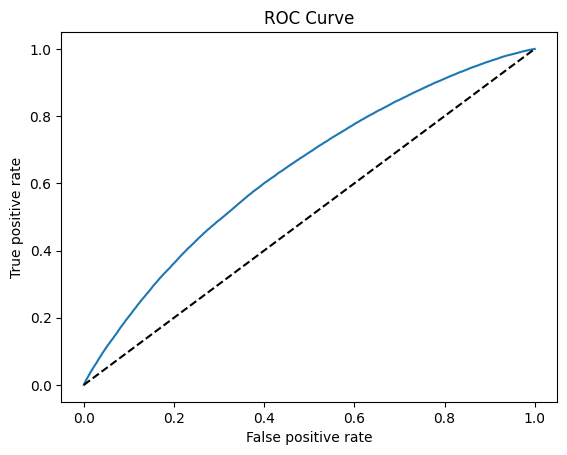

In [129]:
# Graph ROC curve
fpr, tpr, thresholds = roc_curve(logistic_reg_test_results['default'], logistic_reg_test_results['proba_default'])
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle='--', color='k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.show()

In [130]:
# Compute AUC
auc_1 = roc_auc_score(logistic_reg_test_results['default'], logistic_reg_test_results['proba_default'])
auc_1

0.6368557182072454

### Convert numeric features into dummy variables to build the 2nd logistic regression model
1. Apply fine classing to all numeric features to categorize numbers into evenly spaced groups. 
2. Convert updated numeric features into dummy variables.
2. Run logistic regression and examine performance.

In [136]:
# Create a list of numeric features.
# In data_clean, features appear before default column are all numeric.
# Get the index of default column
print([i for i, x in enumerate(data_clean_model.columns.values=='default') if x])

# Store all columns appearing before default into the list
numeric_feature = list(data_clean_model.columns[:45])

[45]


In [137]:
# Define a function to categorize numbers in a numeric feature into one of six evenly spaced groups
# Other number of groups can be used instead of 6. 
# Choosing 6 because the number of dummy variables will be manageable, also they keep more variance in data than using only 3 or 4 groups.
def numeric_fc_6(data, x):
    # First, calculate the lower and upper boundaries of 6 groups in a numeric feature
    # np.linspce returns evenly spaced numbers over a specified interval
    boundary = np.linspace(data[x].min(), data[x].max(), 6)
    data_fc = pd.DataFrame()
    data_fc[x] = np.where(data[x].between(boundary[0], boundary[1], inclusive='left'), 'group_1', \
    np.where(data[x].between(boundary[1], boundary[2], inclusive='left'), 'group_2', \
    np.where(data[x].between(boundary[2], boundary[3], inclusive='left'), 'group_3', \
    np.where(data[x].between(boundary[3], boundary[4], inclusive='left'), 'group_4', \
    np.where(data[x].between(boundary[4], boundary[5], inclusive='left'), 'group_5', 'group_6')))))
    return data_fc

In [138]:
data_numeric_feature_fc = pd.DataFrame()
for i in numeric_feature:
    data_fc = numeric_fc_6(data_clean_model, i)
    data_numeric_feature_fc = pd.concat([data_numeric_feature_fc, data_fc], axis=1)

In [139]:
# Convert updated numeric features into dummy variables
data_clean_fc = pd.concat([data_clean_model.drop(columns=numeric_feature).reset_index(drop=True), pd.get_dummies(data_numeric_feature_fc, drop_first=True)], axis=1)

### 2nd Logistic regression model
- Uses data in data_clean_fc in which all numeric features are applied fine classing and transformed into dummy variables.
- This model performs better than the 1st model with an AUC of 0.73. It's able to achieve a higher true positive rate and a true negative rate.
- Coefficients are on a scale much easier for interpretation.

In [140]:
# Split data into training and testing set
X_2 = data_clean_fc.iloc[:, 1:]
y_2 = data_clean_fc['default']
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=1)

In [142]:
# Build the logistic regression model with training data
logistic_reg_2 = LogisticRegression()
logistic_reg_2.fit(X_2_train, y_2_train)

LogisticRegression()

In [143]:
# Create a dataframe containing coefficients of variables
summary_table_2 = pd.DataFrame(columns=['Feature'], data=X_2_train.columns.values)
summary_table_2['Coefficient'] = np.transpose(logistic_reg_2.coef_)
summary_table_2.sort_values(by='Coefficient', inplace=True)
summary_table_2

,Feature,Coefficient
58,fico_range_low_group_5,-0.908602
217,pct_tl_nvr_dlq_group_2,-0.809810
57,fico_range_low_group_4,-0.646050
219,pct_tl_nvr_dlq_group_4,-0.627924
218,pct_tl_nvr_dlq_group_3,-0.615865
...,...,...
34,int_rate_group_5,1.440397
2,job_group_4,1.492680
35,int_rate_group_6,1.764658
3,job_group_5,1.893866


In [144]:
# Create a dataset containing probabilities of default estimated by the logistic regression and actual default
logistic_reg_test_results_2 = pd.DataFrame(columns=['proba_default'], data=logistic_reg_2.predict_proba(X_2_test)[:, 1])
logistic_reg_test_results_2 = pd.concat([logistic_reg_test_results_2, y_2_test.reset_index().drop(columns='index')], axis=1)
logistic_reg_test_results_2

,proba_default,default
0,0.047684,0
1,0.105442,0
2,0.102116,0
3,0.121726,0
4,0.140187,0
...,...,...
269065,0.094303,0
269066,0.352853,0
269067,0.165542,0
269068,0.131972,0


In [525]:
# Compare probability of default to a cutoff value so that a loan will default when the probability is higher than the cutoff value.
# Let's use the default cutoff of 0.5
logistic_reg_test_results_2['predicted_default'] = np.where(logistic_reg_test_results_2['proba_default']>=0.5, 1, 0)

# Build confusion matrix with pd.crosstab()
pd.crosstab(logistic_reg_test_results_2['default'], logistic_reg_test_results_2['predicted_default'], rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,210841,4618
1,47488,6123


In [551]:
logistic_reg_test_results_2['predicted_default'] = np.where(logistic_reg_test_results_2['proba_default']>=0.5, 1, 0)

# Build confusion matrix with pd.crosstab()
pd.crosstab(logistic_reg_test_results_2['default'], logistic_reg_test_results_2['predicted_default'], rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,210841,4618
1,47488,6123


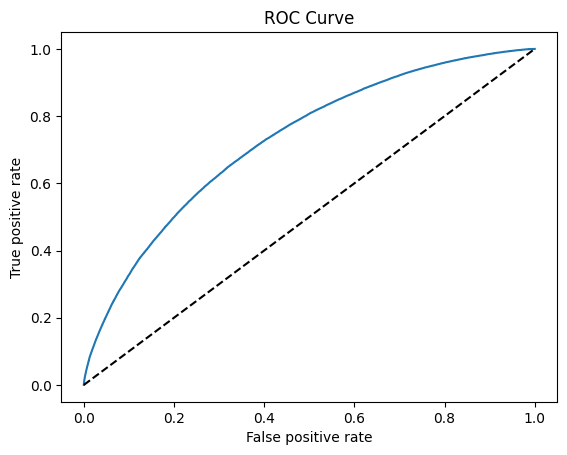

In [526]:
# Graph ROC curve
fpr_2, tpr_2, thresholds_2 = roc_curve(logistic_reg_test_results_2['default'], logistic_reg_test_results_2['proba_default'])
plt.plot(fpr_2, tpr_2)
plt.plot(fpr_2, fpr_2, linestyle='--', color='k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.show()

In [145]:
# Compute AUC
auc_2 = roc_auc_score(logistic_reg_test_results_2['default'], logistic_reg_test_results_2['proba_default'])
auc_2

0.7270427318201285

### Categorize data in numeric features to fewer groups for simpler models
- The 2nd logistic regression model performed much better than the 1st one, but it contains 236 features.
- Let's see if the model can achieve similar performance when splitting numeric features into only 3 groups instead of 6 groups.

In [687]:
# Define a function to categorize numbers in a numeric feature into one of the three groups based on percentile
def numeric_fc_3(data, x):
    data_fc = pd.DataFrame()
    data_fc[x] = np.where(data[x].between(np.percentile(data[x], 0), np.percentile(data[x], 33), inclusive='left'), 'group_1', \
    np.where(data[x].between(np.percentile(data[x], 33), np.percentile(data[x], 66), inclusive='left'), 'group_2', 'group_3'))
    return data_fc

In [784]:
data_numeric_feature_fc_3 = pd.DataFrame()
for i in numeric_feature:
    data_fc_3 = numeric_fc_3(data_clean_model, i)
    data_numeric_feature_fc_3 = pd.concat([data_numeric_feature_fc_3, data_fc_3], axis=1)

In [785]:
# Convert updated numeric features into dummy variables
data_clean_fc_3 = pd.concat([data_clean_model.drop(columns=numeric_feature).reset_index(drop=True), pd.get_dummies(data_numeric_feature_fc_3, drop_first=True)], axis=1)

### 3rd Logistic regression model
- Uses data in data_clean_fc_3. Data in numeric features are categorized into 3 groups, so each feature has 2 dummy variables. If not, it means the feature doesn't have any data in a certain percentile range.
- Compared to the 2nd model, this model's AUC improved by 1.1% to 0.74 with 80 features.

In [786]:
# Split data into training and testing set
X_3 = data_clean_fc_3.iloc[:, 1:]
y_3 = data_clean_fc_3['default']
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=0.2, random_state=1)

In [787]:
# Build the logistic regression model with training data
logistic_reg_3 = LogisticRegression()
logistic_reg_3.fit(X_3_train, y_3_train)

LogisticRegression()

In [788]:
# Create a dataframe containing coefficients of variables
summary_table_3 = pd.DataFrame(columns=['Feature'], data=X_3_train.columns.values)
summary_table_3['Coefficient'] = np.transpose(logistic_reg_3.coef_)
summary_table_3.sort_values(by='Coefficient', inplace=True)
summary_table_3

,Feature,Coefficient
11,car,-0.454391
12,credit_card_or_educational,-0.419101
17,other_or_debt_consolidation,-0.343254
37,fico_range_low_group_3,-0.282539
13,home_improvement,-0.282522
...,...,...
29,int_rate_group_3,0.804900
1,job_group_3,0.915714
2,job_group_4,1.409696
3,job_group_5,1.799059


In [789]:
# Create a dataset containing probabilities of default estimated by the logistic regression and actual default
logistic_reg_test_results_3 = pd.DataFrame(columns=['proba_default'], data=logistic_reg_3.predict_proba(X_3_test)[:, 1])
logistic_reg_test_results_3 = pd.concat([logistic_reg_test_results_3, y_3_test.reset_index().drop(columns='index')], axis=1)
logistic_reg_test_results_3

,proba_default,default
0,0.108177,0
1,0.130050,0
2,0.089407,0
3,0.156660,0
4,0.167681,0
...,...,...
269065,0.070472,0
269066,0.290057,0
269067,0.183408,0
269068,0.156917,0


In [790]:
# Compare probability of default to a cutoff value so that a loan will default when the probability is higher than the cutoff value.
# Let's use the default cutoff of 0.5
logistic_reg_test_results_3['predicted_default'] = np.where(logistic_reg_test_results_3['proba_default']>=0.5, 1, 0)

# Build confusion matrix with pd.crosstab()
pd.crosstab(logistic_reg_test_results_3['default'], logistic_reg_test_results_3['predicted_default'], rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,210640,4819
1,46880,6731


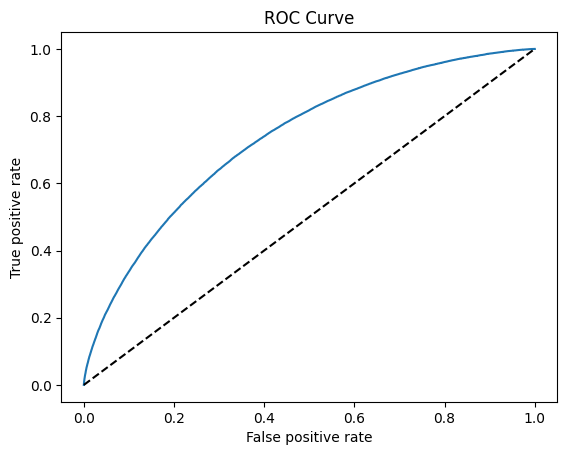

In [791]:
# Graph ROC curve
fpr_3, tpr_3, thresholds_3 = roc_curve(logistic_reg_test_results_3['default'], logistic_reg_test_results_3['proba_default'])
plt.plot(fpr_3, tpr_3)
plt.plot(fpr_3, fpr_3, linestyle='--', color='k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.show()

In [792]:
# Compute AUC
auc_3 = roc_auc_score(logistic_reg_test_results_3['default'], logistic_reg_test_results_3['proba_default'])
auc_3

0.7353978310055963

In [794]:
# Compared to the 2nd model, AUC of this model decreased by 0.85%
100*(auc_3-auc_2)/auc_2

1.1491895620153048

### Remove variables for a simpler model
- Examine coefficients of variables in the 3rd logistic regression model and remove variables without much predictive power
- The objective is to achieve similar predictive performance with a simpler model
- Create lists of variables with the absolute coefficient value less than a threshold and calculate AUC of models trained with each list of variables removed

In [795]:
# Lists of features to remove from training data, and calculate AUC of model trained with each list of features removed
feature_rm_1 = list(summary_table_3[abs(summary_table_3['Coefficient'])<=0.03]['Feature'])
feature_rm_2 = list(summary_table_3[abs(summary_table_3['Coefficient'])<=0.06]['Feature'])
feature_rm_3 = list(summary_table_3[abs(summary_table_3['Coefficient'])<=0.1]['Feature'])
feature_rm_4 = list(summary_table_3[abs(summary_table_3['Coefficient'])<=0.15]['Feature'])
feature_rm_5 = list(summary_table_3[abs(summary_table_3['Coefficient'])<=0.2]['Feature'])
feature_rm_6 = list(summary_table_3[abs(summary_table_3['Coefficient'])<=0.3]['Feature'])
feature_rm_7 = list(summary_table_3[abs(summary_table_3['Coefficient'])<=0.4]['Feature'])
feature_rm_8 = list(summary_table_3[abs(summary_table_3['Coefficient'])<=0.5]['Feature'])

### Compare AUC of models with variables in the lists removed to check if a simpler model is possible
- Model can maintain an AUC of 0.72 with 57 variables removed. 
- For the next step, I'm going to re-engineer the remaining features trying to achieve a better performance.
- While examining the features remained, I found most of the dummy variables derived from numeric features were removed, meaning these numeric features don't have strong predictive power. However, this may indicate the way these numeric features transformed to dummy variables was not appropriate. So I will also re-engineer some important numeric features aiming to achieve a better performance.

In [838]:
# Define a function to calculate AUC with a list of features removed
def auc_rm_feature(data, feature_rm):
    x = data.drop(columns=feature_rm).drop(columns='default')
    y = data['default']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
    lg = LogisticRegression()
    lg.fit(x_train, y_train)
    auc_score = round(roc_auc_score(y_test, lg.predict_proba(x_test)[:, 1]), 2)
    return auc_score

In [799]:
# Create a dataset to store AUC of models with the lists of features removed
feature_rm_df = pd.DataFrame({'Feature_rm_list':['feature_rm_1', 'feature_rm_2', 'feature_rm_3', 'feature_rm_4', \
    'feature_rm_5', 'feature_rm_6', 'feature_rm_7', 'feature_rm_8'],\
    '#_features_rm': [len(i) for i in [feature_rm_1, feature_rm_2, feature_rm_3, feature_rm_4, feature_rm_5, feature_rm_6, feature_rm_7, feature_rm_8]],\
    '#_features_remain': [X_3_train.shape[1]-len(i) for i in [feature_rm_1, feature_rm_2, feature_rm_3, feature_rm_4, feature_rm_5, feature_rm_6, feature_rm_7, feature_rm_8]],\
    'AUC':np.nan})

# Calculate AUC of models
feature_rm_auc = []
for i in [feature_rm_1, feature_rm_2, feature_rm_3, feature_rm_4, feature_rm_5, feature_rm_6, feature_rm_7, feature_rm_8]:
    feature_rm_auc.append(auc_rm_feature(data_clean_fc_3, i))

In [804]:
feature_rm_df['AUC'] = feature_rm_auc
feature_rm_df

,Feature_rm_list,#_features_rm,#_features_remain,AUC
0,feature_rm_1,9,71,0.74
1,feature_rm_2,18,62,0.74
2,feature_rm_3,30,50,0.73
3,feature_rm_4,48,32,0.73
4,feature_rm_5,57,23,0.72
5,feature_rm_6,64,16,0.72
6,feature_rm_7,69,11,0.71
7,feature_rm_8,73,7,0.70


In [817]:
# Check remaining variables after removing variables in feature_rm_5
# Chose to remove features in feature_rm_5 because there are 23 variables remaining, which is manageable for further feature engineering.
# Also, the AUC is 0.72, only 2.7% worse than model with 80 variables.
X_3_train.drop(columns=feature_rm_5).head()

,job_group_2,job_group_3,job_group_4,job_group_5,job_group_6,loan_term_60,RENT,car,credit_card_or_educational,home_improvement,major_purchase,other_or_debt_consolidation,vacation,state_group_2,state_group_3,state_group_4,state_group_5,loan_amnt_group_3,int_rate_group_2,int_rate_group_3,dti_group_3,fico_range_low_group_3,acc_open_past_24mths_group_3
1248336,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,1
521035,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1
1061403,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0
311422,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0
352313,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


#### Before re-engineering the features, run a model with selected features to see how model performs
- __Remaining features__: emp_title, term, home_ownership, purpose, addr_state, loan_amnt, int_rate, dti, fico_range_low, acc_open_past_24mths
- AUC is including dummy variables of the remaining features

In [829]:
# Create a dataset containing all dummy variables for the remaining features
data_clean_fc_3_rm = pd.concat([data_clean_fc_3.filter(regex='default|job_group|loan_term|OTHER|OWN|RENT|state_group|loan_amnt|int_rate|dti|fico_range_low|acc_open_past_24mths'), \
    data_clean_model[['car', 'credit_card_or_educational', 'home_improvement', 'major_purchase', 'medical_or_house', 'moving_or_renewable_energy', \
    'other_or_debt_consolidation', 'small_business', 'vacation']].reset_index(drop=True)], axis=1)

In [831]:
# Split data into training and testing set
X_3_rm = data_clean_fc_3_rm.iloc[:, 1:]
y_3_rm = data_clean_fc_3_rm['default']
X_3_train_rm, X_3_test_rm, y_3_train_rm, y_3_test_rm = train_test_split(X_3_rm, y_3_rm, test_size=0.2, random_state=1)

# Build the logistic regression model with training data
logistic_reg_3_rm = LogisticRegression()
logistic_reg_3_rm.fit(X_3_train_rm, y_3_train_rm)

LogisticRegression()

In [919]:
# Create a dataframe containing coefficients of variables
summary_table_3_rm = pd.DataFrame(columns=['Feature'], data=X_3_train_rm.columns.values)
summary_table_3_rm['Coefficient'] = np.transpose(logistic_reg_3_rm.coef_)
summary_table_3_rm.sort_values(by='Coefficient', inplace=True)
summary_table_3_rm

,Feature,Coefficient
15,fico_range_low_group_3,-0.390254
18,car,-0.132034
14,fico_range_low_group_2,-0.130797
19,credit_card_or_educational,-0.083129
20,home_improvement,0.041103
21,major_purchase,0.050236
8,loan_amnt_group_2,0.130918
22,medical_or_house,0.135578
12,dti_group_2,0.136833
16,acc_open_past_24mths_group_2,0.140183


In [1141]:
auc_rm_feature(data_clean_fc_3_rm, [])

0.73

### Re-engineer the remaning features & Check model performance
- __emp_title__: Split into 7 groups instead of 6.
- __term__ can't be split further.
- __home_ownership__: Group RENT and OTHER together.
- __purpose__: Group purposes with similar coefficients together.
- __addr_state__: Group state_group_3, state_group_4 and state_group_5 together
- __loan_amnt__: Remove this variable.
- __int_rate__: Group int_rate_group_3, int_rate_group_4, int_rate_group_5, and int_rate_group_6 together.
- __dti__: Split dti into 4 groups with one group containing only outliers.
- __fico_range_low__: Group fico_range_low_group_1 and fico_range_low_group_2 together.
- __acc_open_past_24mths__: Stick with the 3 acc_open_past_24mths dummy variables.

In [1149]:
# Create a dataframe to store re-engineered features
data_feature_reeng = pd.DataFrame()

#### emp_title:
- emp_title was converted to dummy variables based on arbitrary WOE.
- For this processing, split job titles using percentile of WOE. In this way, job titles in the same group have more similar predictive power and may improve model performance.
- Replace dummy variables converted from emp_title in the 3rd logistic regression with the updated dummy variables. Test if this improves results. 
- Splitting emp_title into 7 groups instead of 6. 

##### Split emp_title into 5 groups instead of 6:
- AUC is 0.73.

In [1203]:
job_group_1_reeng = list(emp_title_woe_iv[emp_title_woe_iv['WOE'].between(np.percentile(emp_title_woe_iv['WOE'], 0), np.percentile(emp_title_woe_iv['WOE'], 20), inclusive='left')]['emp_title'])
job_group_2_reeng = list(emp_title_woe_iv[emp_title_woe_iv['WOE'].between(np.percentile(emp_title_woe_iv['WOE'], 20), np.percentile(emp_title_woe_iv['WOE'], 40), inclusive='left')]['emp_title'])
job_group_3_reeng = list(emp_title_woe_iv[emp_title_woe_iv['WOE'].between(np.percentile(emp_title_woe_iv['WOE'], 40), np.percentile(emp_title_woe_iv['WOE'], 60), inclusive='left')]['emp_title'])
job_group_4_reeng = list(emp_title_woe_iv[emp_title_woe_iv['WOE'].between(np.percentile(emp_title_woe_iv['WOE'], 60), np.percentile(emp_title_woe_iv['WOE'], 80), inclusive='left')]['emp_title'])
job_group_5_reeng = list(emp_title_woe_iv[emp_title_woe_iv['WOE']>=np.percentile(emp_title_woe_iv['WOE'], 80)]['emp_title'])

In [1204]:
# When a job title can't be found in any of the groups, it means the job title in "other" group. Other has WOE of -0.39 and belongs to the first group
data_feature_reeng['job_group_reeng'] = np.where(data_clean['emp_title'].isin(job_group_1_reeng), 1, \
    np.where(data_clean['emp_title'].isin(job_group_2_reeng), 2, \
    np.where(data_clean['emp_title'].isin(job_group_3_reeng), 3, \
    np.where(data_clean['emp_title'].isin(job_group_4_reeng), 4, \
    np.where(data_clean['emp_title'].isin(job_group_5_reeng), 5, 1)))))

data_clean_job_reeng = pd.concat([data_clean_fc_3_rm.drop(columns=['job_group_2', 'job_group_3', 'job_group_4', 'job_group_5', 'job_group_6']), \
    pd.get_dummies(data_feature_reeng['job_group_reeng'], prefix='job_group_reeng', drop_first=True)], axis=1)

In [1207]:
data_feature_reeng['job_group_reeng'].value_counts()

1    653714
2    372172
3    257560
4     37022
5     24882
Name: job_group_reeng, dtype: int64

In [1213]:
# Split data into training and testing set
X_3_job = data_clean_job_reeng.iloc[:, 1:]
y_3_job = data_clean_job_reeng['default']
X_3_train_job, X_3_test_job, y_3_train_job, y_3_test_job = train_test_split(X_3_job, y_3_job, test_size=0.2, random_state=1)

# Build the logistic regression model with training data
logistic_reg_3_job = LogisticRegression()
logistic_reg_3_job.fit(X_3_train_job, y_3_train_job)

LogisticRegression()

In [1214]:
# Create a dataframe containing coefficients of variables
summary_table_3_job = pd.DataFrame(columns=['Feature'], data=X_3_train_job.columns.values)
summary_table_3_job['Coefficient'] = np.transpose(logistic_reg_3_job.coef_)
summary_table_3_job.sort_values(by='Coefficient', inplace=True)
summary_table_3_job

,Feature,Coefficient
15,fico_range_low_group_3,-0.396444
14,fico_range_low_group_2,-0.131986
8,loan_amnt_group_2,0.132422
16,acc_open_past_24mths_group_2,0.138927
12,dti_group_2,0.142127
4,state_group_2,0.213108
2,OWN,0.216847
18,car,0.218511
9,loan_amnt_group_3,0.253601
19,credit_card_or_educational,0.261760


In [1215]:
# Calculate AUC of model trained with new dummy variables derived from emp_title
auc_rm_feature(data_clean_job_reeng, [])

0.73

##### Further split emp_title into 7 groups since coefficients of emp_title dummy variables are big, indicating high discriminating power
- Maybe splitting this feature further will improve model performance.
- AUC of model is still 0.73, but the coefficients of emp_title dummy variables are big and very different from each other.
- So we want to keep all the dummy variables to better predict the probability of default.

In [1269]:
job_group_1_reeng = list(emp_title_woe_iv[emp_title_woe_iv['WOE'].between(np.percentile(emp_title_woe_iv['WOE'], 0), np.percentile(emp_title_woe_iv['WOE'], 20), inclusive='left')]['emp_title'])
job_group_2_reeng = list(emp_title_woe_iv[emp_title_woe_iv['WOE'].between(np.percentile(emp_title_woe_iv['WOE'], 20), np.percentile(emp_title_woe_iv['WOE'], 40), inclusive='left')]['emp_title'])
job_group_3_reeng = list(emp_title_woe_iv[emp_title_woe_iv['WOE'].between(np.percentile(emp_title_woe_iv['WOE'], 40), np.percentile(emp_title_woe_iv['WOE'], 60), inclusive='left')]['emp_title'])
job_group_4_reeng = list(emp_title_woe_iv[emp_title_woe_iv['WOE'].between(np.percentile(emp_title_woe_iv['WOE'], 60), np.percentile(emp_title_woe_iv['WOE'], 80), inclusive='left')]['emp_title'])
job_group_5_reeng = list(emp_title_woe_iv[emp_title_woe_iv['WOE'].between(np.percentile(emp_title_woe_iv['WOE'], 80), np.percentile(emp_title_woe_iv['WOE'], 95), inclusive='left')]['emp_title'])
job_group_6_reeng = list(emp_title_woe_iv[emp_title_woe_iv['WOE'].between(np.percentile(emp_title_woe_iv['WOE'], 95), np.percentile(emp_title_woe_iv['WOE'], 97), inclusive='left')]['emp_title'])
job_group_7_reeng = list(emp_title_woe_iv[emp_title_woe_iv['WOE']>=np.percentile(emp_title_woe_iv['WOE'], 97)]['emp_title'])

In [1271]:
# When a job title can't be found in any of the groups, it means the job title in "other" group. Other has WOE of -0.39 and belongs to the first group
data_feature_reeng['job_group_reeng_2'] = np.where(data_clean['emp_title'].isin(job_group_1_reeng), 1, \
    np.where(data_clean['emp_title'].isin(job_group_2_reeng), 2, \
    np.where(data_clean['emp_title'].isin(job_group_3_reeng), 3, \
    np.where(data_clean['emp_title'].isin(job_group_4_reeng), 4, \
    np.where(data_clean['emp_title'].isin(job_group_5_reeng), 5, \
    np.where(data_clean['emp_title'].isin(job_group_6_reeng), 6, \
    np.where(data_clean['emp_title'].isin(job_group_7_reeng), 7, 1)))))))

data_clean_job_reeng = pd.concat([data_clean_fc_3_rm.drop(columns=['job_group_2', 'job_group_3', 'job_group_4', 'job_group_5', 'job_group_6']), \
    pd.get_dummies(data_feature_reeng['job_group_reeng_2'], prefix='job_group_reeng', drop_first=True)], axis=1)

In [1272]:
# Split data into training and testing set
X_3_job = data_clean_job_reeng.iloc[:, 1:]
y_3_job = data_clean_job_reeng['default']
X_3_train_job, X_3_test_job, y_3_train_job, y_3_test_job = train_test_split(X_3_job, y_3_job, test_size=0.2, random_state=1)

# Build the logistic regression model with training data
logistic_reg_3_job = LogisticRegression()
logistic_reg_3_job.fit(X_3_train_job, y_3_train_job)

LogisticRegression()

In [1273]:
# Create a dataframe containing coefficients of variables
summary_table_3_job = pd.DataFrame(columns=['Feature'], data=X_3_train_job.columns.values)
summary_table_3_job['Coefficient'] = np.transpose(logistic_reg_3_job.coef_)
summary_table_3_job.sort_values(by='Coefficient', inplace=True)
summary_table_3_job

,Feature,Coefficient
15,fico_range_low_group_3,-0.397328
14,fico_range_low_group_2,-0.132555
8,loan_amnt_group_2,0.132564
18,car,0.133959
16,acc_open_past_24mths_group_2,0.139180
12,dti_group_2,0.142082
19,credit_card_or_educational,0.182089
4,state_group_2,0.211956
2,OWN,0.216933
9,loan_amnt_group_3,0.254063


In [1274]:
# Calculate AUC of model trained with new dummy variables derived from emp_title
auc_rm_feature(data_clean_job_reeng, [])

0.73

In [1276]:
# Keep job_group_reeng_2 and drop job_group_reeng
data_feature_reeng = data_feature_reeng.drop(columns='job_group_reeng')
data_feature_reeng.rename(columns={'job_group_reeng_2':'job_group_reeng'}, inplace=True)

#### home_ownership
- AUC improves to 0.73 after grouping RENT and OTHER together. 

In [891]:
# Coefficients of RENT and OTHER differ by only 0.1. Try grouping them together and check model performance
data_clean_home_reeng = data_clean_fc_3_rm.copy()
data_clean_home_reeng['RENT_OTHER'] = data_clean_home_reeng['RENT']+data_clean_home_reeng['OTHER']
data_clean_home_reeng.drop(columns=['RENT', 'OTHER'], inplace=True)

In [892]:
auc_rm_feature(data_clean_home_reeng, [])

0.73

In [1278]:
data_clean_fc_3_rm.head()

,default,job_group_2,job_group_3,job_group_4,job_group_5,job_group_6,loan_term_60,OTHER,OWN,RENT,state_group_2,state_group_3,state_group_4,state_group_5,loan_amnt_group_2,loan_amnt_group_3,int_rate_group_2,int_rate_group_3,dti_group_2,dti_group_3,fico_range_low_group_2,fico_range_low_group_3,acc_open_past_24mths_group_2,acc_open_past_24mths_group_3,car,credit_card_or_educational,home_improvement,major_purchase,medical_or_house,moving_or_renewable_energy,other_or_debt_consolidation,small_business,vacation
0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [1280]:
data_feature_reeng['home_ownership_reeng'] = np.where(data_clean['home_ownership'].isin(['OTHER', 'RENT']), 'RENT_OTHER', data_clean['home_ownership'])

#### purpose
- Group purposes with similar coefficients together.

##### Include all purposes as dummy variables
- AUC is still 0.73.

In [894]:
data_clean_purpose_reeng = pd.concat([data_clean_fc_3.filter(regex='default|job_group|loan_term|OTHER|OWN|RENT|state_group|loan_amnt|int_rate|dti|fico_range_low|acc_open_past_24mths'), \
    pd.get_dummies(data_clean['purpose'], drop_first=True).reset_index(drop=True)], axis=1)

In [895]:
# Split data into training and testing set
X_3_purpose = data_clean_purpose_reeng.iloc[:, 1:]
y_3_purpose = data_clean_purpose_reeng['default']
X_3_train_purpose, X_3_test_purpose, y_3_train_purpose, y_3_test_purpose = train_test_split(X_3_purpose, y_3_purpose, test_size=0.2, random_state=1)

# Build the logistic regression model with training data
logistic_reg_3_purpose = LogisticRegression()
logistic_reg_3_purpose.fit(X_3_purpose, y_3_purpose)

LogisticRegression()

In [896]:
# Create a dataframe containing coefficients of variables
summary_table_3_purpose = pd.DataFrame(columns=['Feature'], data=X_3_train_purpose.columns.values)
summary_table_3_purpose['Coefficient'] = np.transpose(logistic_reg_3_purpose.coef_)
summary_table_3_purpose.sort_values(by='Coefficient', inplace=True)
summary_table_3_purpose

,Feature,Coefficient
20,fico_range_low_group_3,-0.399508
35,wedding,-0.209475
19,fico_range_low_group_2,-0.137857
23,credit_card,0.043398
24,debt_consolidation,0.111355
27,house,0.132011
21,acc_open_past_24mths_group_2,0.137486
13,loan_amnt_group_2,0.141106
17,dti_group_2,0.145541
26,home_improvement,0.163283


In [897]:
# Calculate AUC
auc_rm_feature(data_clean_purpose_reeng, [])

0.73

##### Group purposes with similar coefficients together
- credit_card, debt_consolidation, house
- home_improvement, vacation, other, major_purchase
- moving, renewable_energy, educational, medical
- AUC is still 0.73.

In [1283]:
data_clean_purpose_reeng.head()

,default,job_group_2,job_group_3,job_group_4,job_group_5,job_group_6,loan_term_60,OTHER,OWN,RENT,state_group_2,state_group_3,state_group_4,state_group_5,loan_amnt_group_2,loan_amnt_group_3,int_rate_group_2,int_rate_group_3,dti_group_2,dti_group_3,fico_range_low_group_2,fico_range_low_group_3,acc_open_past_24mths_group_2,acc_open_past_24mths_group_3,credit_card,debt_consolidation,educational,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding
0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [905]:
data_clean_purpose_reeng_2 = data_clean_purpose_reeng.copy()
data_clean_purpose_reeng_2['credit_card|debt_consolidation|house'] = data_clean_purpose_reeng_2['credit_card']+data_clean_purpose_reeng_2['debt_consolidation']+data_clean_purpose_reeng_2['house']
data_clean_purpose_reeng_2['home_improvement|vacation|other|major_purchase'] = data_clean_purpose_reeng_2['home_improvement']+data_clean_purpose_reeng_2['vacation']+data_clean_purpose_reeng_2['other']+data_clean_purpose_reeng_2['major_purchase']
data_clean_purpose_reeng_2['moving|renewable_energy|educational|medical'] = data_clean_purpose_reeng_2['moving']+data_clean_purpose_reeng_2['renewable_energy']+data_clean_purpose_reeng_2['educational']+data_clean_purpose_reeng_2['medical']
data_clean_purpose_reeng_2.drop(columns=['credit_card', 'debt_consolidation', 'house', 'home_improvement', 'vacation', 'other', 'major_purchase', \
    'moving', 'renewable_energy', 'educational', 'medical'], inplace=True)

In [906]:
# Split data into training and testing set
X_3_purpose = data_clean_purpose_reeng_2.iloc[:, 1:]
y_3_purpose = data_clean_purpose_reeng_2['default']
X_3_train_purpose, X_3_test_purpose, y_3_train_purpose, y_3_test_purpose = train_test_split(X_3_purpose, y_3_purpose, test_size=0.2, random_state=1)

# Build the logistic regression model with training data
logistic_reg_3_purpose = LogisticRegression()
logistic_reg_3_purpose.fit(X_3_purpose, y_3_purpose)

LogisticRegression()

In [907]:
# Create a dataframe containing coefficients of variables
summary_table_3_purpose = pd.DataFrame(columns=['Feature'], data=X_3_train_purpose.columns.values)
summary_table_3_purpose['Coefficient'] = np.transpose(logistic_reg_3_purpose.coef_)
summary_table_3_purpose.sort_values(by='Coefficient', inplace=True)
summary_table_3_purpose

,Feature,Coefficient
20,fico_range_low_group_3,-0.396673
24,wedding,-0.241116
19,fico_range_low_group_2,-0.137713
25,credit_card|debt_consolidation|house,0.093455
21,acc_open_past_24mths_group_2,0.138928
13,loan_amnt_group_2,0.140606
17,dti_group_2,0.145120
26,home_improvement|vacation|other|major_purchase,0.172362
6,OTHER,0.198843
9,state_group_2,0.220283


In [908]:
# Calculate AUC
auc_rm_feature(data_clean_purpose_reeng, [])

0.73

In [1287]:
data_feature_reeng['purpose_reeng'] = np.where(data_clean['purpose'].isin(['credit_card', 'debt_consolidation', 'house']), 'credit_card|debt_consolidation|house', \
    np.where(data_clean['purpose'].isin(['home_improvement', 'vacation', 'other', 'major_purchase']), 'home_improvement|vacation|other|major_purchase', \
    np.where(data_clean['purpose'].isin(['moving', 'renewable_energy', 'educational', 'medical']), 'moving|renewable_energy|educational|medical', data_clean['purpose'])))

#### addr_state
- Group state_group_3, state_group_4 and state_group_5 together. AUC can still maintain 0.73.

In [934]:
# Based on coefficients in summary_table_3_rm, group state_group_3, state_group_4 and state_group_5 together to check model performance
data_clean_state_reeng = data_clean_fc_3_rm.copy()
data_clean_state_reeng['state_group_3'] = data_clean_state_reeng['state_group_3']+data_clean_state_reeng['state_group_4']+data_clean_state_reeng['state_group_5']
data_clean_state_reeng.drop(columns=['state_group_4', 'state_group_5'], inplace=True)

In [935]:
# Split data into training and testing set
X_3_state = data_clean_state_reeng.iloc[:, 1:]
y_3_state = data_clean_state_reeng['default']
X_3_train_state, X_3_test_state, y_3_train_state, y_3_test_state = train_test_split(X_3_state, y_3_state, test_size=0.2, random_state=1)

# Build the logistic regression model with training data
logistic_reg_3_state = LogisticRegression()
logistic_reg_3_state.fit(X_3_train_state, y_3_train_state)

LogisticRegression()

In [936]:
# Create a dataframe containing coefficients of variables
summary_table_3_state = pd.DataFrame(columns=['Feature'], data=X_3_train_state.columns.values)
summary_table_3_state['Coefficient'] = np.transpose(logistic_reg_3_state.coef_)
summary_table_3_state.sort_values(by='Coefficient', inplace=True)
summary_table_3_state

,Feature,Coefficient
18,fico_range_low_group_3,-0.394972
17,fico_range_low_group_2,-0.133155
11,loan_amnt_group_2,0.127113
19,acc_open_past_24mths_group_2,0.135201
15,dti_group_2,0.142521
21,car,0.207817
9,state_group_2,0.210637
7,OWN,0.226935
12,loan_amnt_group_3,0.247829
22,credit_card_or_educational,0.262872


In [937]:
# Calculate AUC
auc_rm_feature(data_clean_state_reeng, [])

0.73

In [1297]:
data_feature_reeng['addr_state_reeng'] = np.where(data_clean['addr_state'].isin(list(state_group_1)), 'state_group_1', \
    np.where(data_clean['addr_state'].isin(list(state_group_2)), 'state_group_2', 'state_group_3'))

#### loan_amnt

##### Split loan_amnt into 5 evenly spaced groups to check model performance

In [1010]:
loan_amnt_boundary = np.linspace(data_clean_model['loan_amnt'].min(), data_clean_model['loan_amnt'].max(), 6)
data_clean_model['loan_amnt_group'] = np.where(data_clean_model['loan_amnt'].between(loan_amnt_boundary[0], loan_amnt_boundary[1], inclusive='left'), '1', \
    np.where(data_clean_model['loan_amnt'].between(loan_amnt_boundary[1], loan_amnt_boundary[2], inclusive='left'), '2', \
    np.where(data_clean_model['loan_amnt'].between(loan_amnt_boundary[2], loan_amnt_boundary[3], inclusive='left'), '3', \
    np.where(data_clean_model['loan_amnt'].between(loan_amnt_boundary[3], loan_amnt_boundary[4], inclusive='left'), '4', '5'))))

In [1011]:
data_clean_model['loan_amnt_group'].value_counts()

2    503416
1    388155
3    255162
4    128976
5     69641
Name: loan_amnt_group, dtype: int64

In [1014]:
data_clean_loan_reeng = pd.concat([data_clean_fc_3_rm.drop(columns=['loan_amnt_group_2', 'loan_amnt_group_3']), \
    pd.get_dummies(data_clean_model['loan_amnt_group'], prefix='loan_amnt_group', drop_first=True).reset_index(drop=True)], axis=1)

In [1015]:
# Split data into training and testing set
X_3_loan = data_clean_loan_reeng.iloc[:, 1:]
y_3_loan = data_clean_loan_reeng['default']
X_3_train_loan, X_3_test_loan, y_3_train_loan, y_3_test_loan = train_test_split(X_3_loan, y_3_loan, test_size=0.2, random_state=1)

# Build the logistic regression model with training data
logistic_reg_3_loan = LogisticRegression()
logistic_reg_3_loan.fit(X_3_train_loan, y_3_train_loan)

LogisticRegression()

In [1017]:
# Create a dataframe containing coefficients of variables
summary_table_3_loan = pd.DataFrame(columns=['Feature'], data=X_3_train_loan.columns.values)
summary_table_3_loan['Coefficient'] = np.transpose(logistic_reg_3_loan.coef_)
summary_table_3_loan.sort_values(by='Coefficient', inplace=True)
summary_table_3_loan

,Feature,Coefficient
18,fico_range_low_group_3,-0.400941
17,fico_range_low_group_2,-0.134645
19,acc_open_past_24mths_group_2,0.137761
30,loan_amnt_group_2,0.140523
21,car,0.143518
15,dti_group_2,0.144469
22,credit_card_or_educational,0.189532
9,state_group_2,0.210280
7,OWN,0.227963
31,loan_amnt_group_3,0.241588


In [1018]:
auc_rm_feature(data_clean_loan_reeng, [])

0.73

##### Remove loan_amnt dummy variables and check model performance
- loan_amnt dummy variables all have very small coefficients, indicating weak predictive power.
- Remove them and check performance. If model performance doesn't get affected, remove loan_amnt dummy variables from model.
- AUC of model is still 0.73, so remove loan_amnt dummy variables.

In [1043]:
data_clean_loan_reeng = data_clean_fc_3_rm.drop(columns=['loan_amnt_group_2', 'loan_amnt_group_3'])

In [1044]:
# Split data into training and testing set
X_3_loan = data_clean_loan_reeng.iloc[:, 1:]
y_3_loan = data_clean_loan_reeng['default']
X_3_train_loan, X_3_test_loan, y_3_train_loan, y_3_test_loan = train_test_split(X_3_loan, y_3_loan, test_size=0.2, random_state=1)

# Build the logistic regression model with training data
logistic_reg_3_loan = LogisticRegression()
logistic_reg_3_loan.fit(X_3_train_loan, y_3_train_loan)

LogisticRegression()

In [1045]:
# Create a dataframe containing coefficients of variables
summary_table_3_loan = pd.DataFrame(columns=['Feature'], data=X_3_train_loan.columns.values)
summary_table_3_loan['Coefficient'] = np.transpose(logistic_reg_3_loan.coef_)
summary_table_3_loan.sort_values(by='Coefficient', inplace=True)
summary_table_3_loan

,Feature,Coefficient
18,fico_range_low_group_3,-0.372779
17,fico_range_low_group_2,-0.120462
19,acc_open_past_24mths_group_2,0.126951
15,dti_group_2,0.149378
21,car,0.179992
7,OWN,0.210693
9,state_group_2,0.211053
22,credit_card_or_educational,0.287074
10,state_group_3,0.327572
29,vacation,0.328582


In [1046]:
auc_rm_feature(data_clean_loan_reeng, [])

0.73

#### int_rate
- Group int_rate_group_3, int_rate_group_4, int_rate_group_5, and int_rate_group_6 together. AUC can maintain 0.73.

##### Split interest rates into 5 groups instead of 3
- AUC maintains at 0.73

In [952]:
int_rate_boundary = np.linspace(data_clean_model['int_rate'].min(), data_clean_model['int_rate'].max(), 6)
data_clean_model['int_rate_group'] = np.where(data_clean_model['int_rate'].between(int_rate_boundary[0], int_rate_boundary[1], inclusive='left'), '1', \
    np.where(data_clean_model['int_rate'].between(int_rate_boundary[1], int_rate_boundary[2], inclusive='left'), '2', \
    np.where(data_clean_model['int_rate'].between(int_rate_boundary[2], int_rate_boundary[3], inclusive='left'), '3', \
    np.where(data_clean_model['int_rate'].between(int_rate_boundary[3], int_rate_boundary[4], inclusive='left'), '4', '5'))))

In [953]:
data_clean_model['int_rate_group'].value_counts()

2    564990
1    395691
3    286957
4     79455
5     18257
Name: int_rate_group, dtype: int64

In [954]:
data_clean_int_reeng = pd.concat([data_clean_fc_3_rm.drop(columns=['int_rate_group_2', 'int_rate_group_3']), \
    pd.get_dummies(data_clean_model['int_rate_group'], prefix='int_rate_group', drop_first=True).reset_index(drop=True)], axis=1)

In [955]:
# Split data into training and testing set
X_3_int = data_clean_int_reeng.iloc[:, 1:]
y_3_int = data_clean_int_reeng['default']
X_3_train_int, X_3_test_int, y_3_train_int, y_3_test_int = train_test_split(X_3_int, y_3_int, test_size=0.2, random_state=1)

# Build the logistic regression model with training data
logistic_reg_3_int = LogisticRegression()
logistic_reg_3_int.fit(X_3_train_int, y_3_train_int)

LogisticRegression()

In [956]:
# Create a dataframe containing coefficients of variables
summary_table_3_int = pd.DataFrame(columns=['Feature'], data=X_3_train_int.columns.values)
summary_table_3_int['Coefficient'] = np.transpose(logistic_reg_3_int.coef_)
summary_table_3_int.sort_values(by='Coefficient', inplace=True)
summary_table_3_int

,Feature,Coefficient
18,fico_range_low_group_3,-0.369014
17,fico_range_low_group_2,-0.122945
19,acc_open_past_24mths_group_2,0.132679
13,loan_amnt_group_2,0.135232
15,dti_group_2,0.142005
21,car,0.162379
9,state_group_2,0.210422
7,OWN,0.215848
22,credit_card_or_educational,0.232225
14,loan_amnt_group_3,0.247676


In [957]:
auc_rm_feature(data_clean_int_reeng, [])

0.73

##### Split interest rates into 6 groups
- AUC maintains at 0.73
- At this point, splitting interest rates further doesn't seem to improve model performance.

In [958]:
int_rate_boundary = np.linspace(data_clean_model['int_rate'].min(), data_clean_model['int_rate'].max(), 7)
data_clean_model['int_rate_group'] = np.where(data_clean_model['int_rate'].between(int_rate_boundary[0], int_rate_boundary[1], inclusive='left'), '1', \
    np.where(data_clean_model['int_rate'].between(int_rate_boundary[1], int_rate_boundary[2], inclusive='left'), '2', \
    np.where(data_clean_model['int_rate'].between(int_rate_boundary[2], int_rate_boundary[3], inclusive='left'), '3', \
    np.where(data_clean_model['int_rate'].between(int_rate_boundary[3], int_rate_boundary[4], inclusive='left'), '4', \
    np.where(data_clean_model['int_rate'].between(int_rate_boundary[4], int_rate_boundary[5], inclusive='left'), '5', '6')))))

In [960]:
data_clean_model['int_rate_group'].value_counts()

2    472501
3    345288
1    326347
4    138719
5     50252
6     12243
Name: int_rate_group, dtype: int64

In [961]:
data_clean_int_reeng = pd.concat([data_clean_fc_3_rm.drop(columns=['int_rate_group_2', 'int_rate_group_3']), \
    pd.get_dummies(data_clean_model['int_rate_group'], prefix='int_rate_group', drop_first=True).reset_index(drop=True)], axis=1)

In [963]:
# Split data into training and testing set
X_3_int = data_clean_int_reeng.iloc[:, 1:]
y_3_int = data_clean_int_reeng['default']
X_3_train_int, X_3_test_int, y_3_train_int, y_3_test_int = train_test_split(X_3_int, y_3_int, test_size=0.2, random_state=1)

# Build the logistic regression model with training data
logistic_reg_3_int = LogisticRegression()
logistic_reg_3_int.fit(X_3_train_int, y_3_train_int)

LogisticRegression()

In [964]:
# Create a dataframe containing coefficients of variables
summary_table_3_int = pd.DataFrame(columns=['Feature'], data=X_3_train_int.columns.values)
summary_table_3_int['Coefficient'] = np.transpose(logistic_reg_3_int.coef_)
summary_table_3_int.sort_values(by='Coefficient', inplace=True)
summary_table_3_int

,Feature,Coefficient
18,fico_range_low_group_3,-0.359179
17,fico_range_low_group_2,-0.122652
19,acc_open_past_24mths_group_2,0.130811
13,loan_amnt_group_2,0.136121
15,dti_group_2,0.141344
9,state_group_2,0.209704
7,OWN,0.215795
21,car,0.240944
14,loan_amnt_group_3,0.249591
22,credit_card_or_educational,0.313277


In [965]:
auc_rm_feature(data_clean_int_reeng, [])

0.73

##### Group int_rate_group with similar coefficients together
- If model performs at the same level, use fewer groups of interest rates.
- Group int_rate_group_3, int_rate_group_4, int_rate_group_5 and int_rate_group_6 together since their coefficients are similar based on the model with 6 interest rate groups.
- AUC still maintains 0.73.

In [997]:
int_rate_boundary = np.linspace(data_clean_model['int_rate'].min(), data_clean_model['int_rate'].max(), 7)
data_clean_model['int_rate_group'] = np.where(data_clean_model['int_rate'].between(int_rate_boundary[0], int_rate_boundary[1], inclusive='left'), '1', \
    np.where(data_clean_model['int_rate'].between(int_rate_boundary[1], int_rate_boundary[2], inclusive='left'), '2', \
    np.where(data_clean_model['int_rate']>=int_rate_boundary[2], '3', None)))

In [1304]:
data_clean_model['int_rate_group'].value_counts()

3    546502
2    472501
1    326347
Name: int_rate_group, dtype: int64

In [999]:
data_clean_int_reeng = pd.concat([data_clean_fc_3_rm.drop(columns=['int_rate_group_2', 'int_rate_group_3']), \
    pd.get_dummies(data_clean_model['int_rate_group'], prefix='int_rate_group', drop_first=True).reset_index(drop=True)], axis=1)

In [1000]:
# Split data into training and testing set
X_3_int = data_clean_int_reeng.iloc[:, 1:]
y_3_int = data_clean_int_reeng['default']
X_3_train_int, X_3_test_int, y_3_train_int, y_3_test_int = train_test_split(X_3_int, y_3_int, test_size=0.2, random_state=1)

# Build the logistic regression model with training data
logistic_reg_3_int = LogisticRegression()
logistic_reg_3_int.fit(X_3_train_int, y_3_train_int)

LogisticRegression()

In [1001]:
# Create a dataframe containing coefficients of variables
summary_table_3_int = pd.DataFrame(columns=['Feature'], data=X_3_train_int.columns.values)
summary_table_3_int['Coefficient'] = np.transpose(logistic_reg_3_int.coef_)
summary_table_3_int.sort_values(by='Coefficient', inplace=True)
summary_table_3_int

,Feature,Coefficient
18,fico_range_low_group_3,-0.394831
17,fico_range_low_group_2,-0.137006
13,loan_amnt_group_2,0.130769
19,acc_open_past_24mths_group_2,0.134134
15,dti_group_2,0.142687
21,car,0.173534
9,state_group_2,0.212648
22,credit_card_or_educational,0.226488
7,OWN,0.226555
14,loan_amnt_group_3,0.258554


In [1002]:
auc_rm_feature(data_clean_int_reeng, [])

0.73

In [1312]:
data_feature_reeng['int_rate_reeng'].value_counts()

3    546502
2    472501
1    326347
Name: int_rate_reeng, dtype: int64

#### dti
- Split dti into 4 groups with one group containing only outliers. AUC can maintain 0.73.

##### Split dti into 5 groups and check model performance
- AUC is still 0.73. Coefficients of dti dummy variables are not very big. This approach doesn't help improve performance.

In [1052]:
data_clean_model['dti_group'] = np.where(data_clean_model['dti'].between(np.percentile(data_clean_model['dti'], 0), np.percentile(data_clean_model['dti'], 20), inclusive='left'), '1', \
    np.where(data_clean_model['dti'].between(np.percentile(data_clean_model['dti'], 20), np.percentile(data_clean_model['dti'], 40), inclusive='left'), '2', \
    np.where(data_clean_model['dti'].between(np.percentile(data_clean_model['dti'], 40), np.percentile(data_clean_model['dti'], 60), inclusive='left'), '3', \
    np.where(data_clean_model['dti'].between(np.percentile(data_clean_model['dti'], 60), np.percentile(data_clean_model['dti'], 80), inclusive='left'), '4', '5'))))

In [1053]:
data_clean_model['dti_group'].value_counts()

4    269284
2    269212
5    269100
1    268880
3    268874
Name: dti_group, dtype: int64

In [1055]:
data_clean_dti_reeng = pd.concat([data_clean_fc_3_rm.drop(columns=['dti_group_2', 'dti_group_3']), \
    pd.get_dummies(data_clean_model['dti_group'], prefix='dti_group', drop_first=True).reset_index(drop=True)], axis=1)

In [1056]:
# Split data into training and testing set
X_3_dti = data_clean_dti_reeng.iloc[:, 1:]
y_3_dti = data_clean_dti_reeng['default']
X_3_train_dti, X_3_test_dti, y_3_train_dti, y_3_test_dti = train_test_split(X_3_dti, y_3_dti, test_size=0.2, random_state=1)

# Build the logistic regression model with training data
logistic_reg_3_dti = LogisticRegression()
logistic_reg_3_dti.fit(X_3_train_dti, y_3_train_dti)

LogisticRegression()

In [1057]:
# Create a dataframe containing coefficients of variables
summary_table_3_dti = pd.DataFrame(columns=['Feature'], data=X_3_train_dti.columns.values)
summary_table_3_dti['Coefficient'] = np.transpose(logistic_reg_3_dti.coef_)
summary_table_3_dti.sort_values(by='Coefficient', inplace=True)
summary_table_3_dti

,Feature,Coefficient
18,fico_range_low_group_3,-0.399263
17,fico_range_low_group_2,-0.134758
30,dti_group_2,0.065178
13,loan_amnt_group_2,0.129190
19,acc_open_past_24mths_group_2,0.135526
31,dti_group_3,0.168856
21,car,0.206034
9,state_group_2,0.213833
7,OWN,0.224182
22,credit_card_or_educational,0.239324


In [1058]:
auc_rm_feature(data_clean_dti_reeng, [])

0.73

##### Split dti into two groups, with one group containing only outliers
- AUC decreased to 0.72 from 0.73, not much decrease, but it would be great to check if any other approach to engineering dti can improve performance. 

In [1063]:
# Calculate threshold for defining outliers
dti_outlier_value = np.percentile(data_clean_model['dti'], 50)+1.5*(np.percentile(data_clean_model['dti'], 75)-np.percentile(data_clean_model['dti'], 25))
dti_outlier_value

36.010000000000005

In [1064]:
data_clean_model['dti_group'] = np.where(data_clean_model['dti']<=dti_outlier_value, '1', '2')

In [1065]:
data_clean_model['dti_group'].value_counts()

1    1317443
2      27907
Name: dti_group, dtype: int64

In [1066]:
data_clean_dti_reeng = pd.concat([data_clean_fc_3_rm.drop(columns=['dti_group_2', 'dti_group_3']), \
    pd.get_dummies(data_clean_model['dti_group'], prefix='dti_group', drop_first=True).reset_index(drop=True)], axis=1)

In [1067]:
# Split data into training and testing set
X_3_dti = data_clean_dti_reeng.iloc[:, 1:]
y_3_dti = data_clean_dti_reeng['default']
X_3_train_dti, X_3_test_dti, y_3_train_dti, y_3_test_dti = train_test_split(X_3_dti, y_3_dti, test_size=0.2, random_state=1)

# Build the logistic regression model with training data
logistic_reg_3_dti = LogisticRegression()
logistic_reg_3_dti.fit(X_3_train_dti, y_3_train_dti)

LogisticRegression()

In [1068]:
# Create a dataframe containing coefficients of variables
summary_table_3_dti = pd.DataFrame(columns=['Feature'], data=X_3_train_dti.columns.values)
summary_table_3_dti['Coefficient'] = np.transpose(logistic_reg_3_dti.coef_)
summary_table_3_dti.sort_values(by='Coefficient', inplace=True)
summary_table_3_dti

,Feature,Coefficient
18,fico_range_low_group_3,-0.375205
17,fico_range_low_group_2,-0.118123
13,loan_amnt_group_2,0.135718
19,acc_open_past_24mths_group_2,0.152678
21,car,0.177527
9,state_group_2,0.209454
7,OWN,0.233584
14,loan_amnt_group_3,0.259655
22,credit_card_or_educational,0.274015
10,state_group_3,0.311971


In [1074]:
auc_rm_feature(data_clean_dti_reeng, [])

0.72

##### Split dti into 4 groups, with one group containing only outleirs
- AUC is still 0.73, but coefficients of dti dummy variables vary much. This can bring extra information while developing scorecard. 

In [1085]:
data_clean_model['dti_group'] = np.where(data_clean_model['dti'].between(np.percentile(data_clean_model['dti'], 0), np.percentile(data_clean_model['dti'], 33), inclusive='left'), '1', \
    np.where(data_clean_model['dti'].between(np.percentile(data_clean_model['dti'], 33), np.percentile(data_clean_model['dti'], 66), inclusive='left'), '2', \
    np.where(data_clean_model['dti'].between(np.percentile(data_clean_model['dti'], 66), dti_outlier_value, inclusive='left'), '3', '4')))

In [1315]:
data_clean_model['dti_group'].value_counts()

2    443878
1    443874
3    429691
4     27907
Name: dti_group, dtype: int64

In [1075]:
data_clean_dti_reeng = pd.concat([data_clean_fc_3_rm.drop(columns=['dti_group_2', 'dti_group_3']), \
    pd.get_dummies(data_clean_model['dti_group'], prefix='dti_group', drop_first=True).reset_index(drop=True)], axis=1)

In [1076]:
# Split data into training and testing set
X_3_dti = data_clean_dti_reeng.iloc[:, 1:]
y_3_dti = data_clean_dti_reeng['default']
X_3_train_dti, X_3_test_dti, y_3_train_dti, y_3_test_dti = train_test_split(X_3_dti, y_3_dti, test_size=0.2, random_state=1)

# Build the logistic regression model with training data
logistic_reg_3_dti = LogisticRegression()
logistic_reg_3_dti.fit(X_3_train_dti, y_3_train_dti)

LogisticRegression()

In [1077]:
# Create a dataframe containing coefficients of variables
summary_table_3_dti = pd.DataFrame(columns=['Feature'], data=X_3_train_dti.columns.values)
summary_table_3_dti['Coefficient'] = np.transpose(logistic_reg_3_dti.coef_)
summary_table_3_dti.sort_values(by='Coefficient', inplace=True)
summary_table_3_dti

,Feature,Coefficient
18,fico_range_low_group_3,-0.395965
17,fico_range_low_group_2,-0.132651
13,loan_amnt_group_2,0.130317
19,acc_open_past_24mths_group_2,0.136522
30,dti_group_2,0.143575
21,car,0.195503
9,state_group_2,0.207597
7,OWN,0.225407
22,credit_card_or_educational,0.236233
14,loan_amnt_group_3,0.254093


In [1087]:
auc_rm_feature(data_clean_dti_reeng, [])

0.73

In [1316]:
data_feature_reeng['dti_reeng'] = data_clean_model['dti_group'].values

#### fico_range_low

##### Group fico_range_low_group_1 and fico_range_low_group_2 together
- Based on summary_table_3_rm, coefficient of fico_range_low_group_2 is -0.13, indicating weak predictive power.
- AUC maintains 0.73.

In [1097]:
data_clean_model['fico_range_low_group'] = np.where(data_clean_model['fico_range_low'].between(data_clean_model['fico_range_low'].min(), np.percentile(data_clean_model['fico_range_low'], 66), 'left'), '1', '2')

In [1318]:
data_clean_model['fico_range_low_group'].value_counts()

1    820827
2    524523
Name: fico_range_low_group, dtype: int64

In [1101]:
data_clean_fico_reeng = pd.concat([data_clean_fc_3_rm.drop(columns=['fico_range_low_group_2', 'fico_range_low_group_3']), \
    pd.get_dummies(data_clean_model['fico_range_low_group'], prefix='fico_range_low_group', drop_first=True).reset_index(drop=True)], axis=1)

In [1103]:
# Split data into training and testing set
X_3_fico = data_clean_fico_reeng.iloc[:, 1:]
y_3_fico = data_clean_fico_reeng['default']
X_3_train_fico, X_3_test_fico, y_3_train_fico, y_3_test_fico = train_test_split(X_3_fico, y_3_fico, test_size=0.2, random_state=1)

# Build the logistic regression model with training data
logistic_reg_3_fico = LogisticRegression()
logistic_reg_3_fico.fit(X_3_train_fico, y_3_train_fico)

LogisticRegression()

In [1104]:
# Create a dataframe containing coefficients of variables
summary_table_3_fico = pd.DataFrame(columns=['Feature'], data=X_3_train_fico.columns.values)
summary_table_3_fico['Coefficient'] = np.transpose(logistic_reg_3_fico.coef_)
summary_table_3_fico.sort_values(by='Coefficient', inplace=True)
summary_table_3_fico

,Feature,Coefficient
30,fico_range_low_group_2,-0.317334
13,loan_amnt_group_2,0.126919
19,acc_open_past_24mths_group_2,0.136240
17,dti_group_2,0.140518
21,car,0.176416
9,state_group_2,0.209646
7,OWN,0.226578
22,credit_card_or_educational,0.230705
14,loan_amnt_group_3,0.244190
27,other_or_debt_consolidation,0.304172


In [1105]:
auc_rm_feature(data_clean_fico_reeng, [])

0.73

In [1319]:
data_feature_reeng['fico_range_low_reeng'] = data_clean_model['fico_range_low_group'].values

#### acc_open_past_24mths
- Split acc_open_past_24mths into 5 groups instead of 3 and check model performance. It doesn't improve model performance.
- So keep using 3 groups of acc_open_past_24mths.

In [1110]:
acc_open_boundary = np.linspace(data_clean_model['acc_open_past_24mths'].min(), data_clean_model['acc_open_past_24mths'].max(), 6)
data_clean_model['acc_open_group'] = np.where(data_clean_model['acc_open_past_24mths'].between(acc_open_boundary[0], acc_open_boundary[1], inclusive='left'), '1', \
    np.where(data_clean_model['acc_open_past_24mths'].between(acc_open_boundary[1], acc_open_boundary[2], inclusive='left'), '2', \
    np.where(data_clean_model['acc_open_past_24mths'].between(acc_open_boundary[2], acc_open_boundary[3], inclusive='left'), '3', \
    np.where(data_clean_model['acc_open_past_24mths'].between(acc_open_boundary[3], acc_open_boundary[4], inclusive='left'), '4', '5'))))

In [1111]:
# Group 1 contains much more data than other groups. Instead of using the minimum and maximum acc_open_past_24mths to calculate group boundaries, use percentile.
# This will create more evenly sized groups.
data_clean_model['acc_open_group'].value_counts()

1    1315137
2      29716
3        458
4         35
5          4
Name: acc_open_group, dtype: int64

In [1134]:
data_clean_model['acc_open_group'] = np.where(data_clean_model['acc_open_past_24mths'].between(np.percentile(data_clean_model['acc_open_past_24mths'], 0), np.percentile(data_clean_model['acc_open_past_24mths'], 20), inclusive='left'), '1', \
    np.where(data_clean_model['acc_open_past_24mths'].between(np.percentile(data_clean_model['acc_open_past_24mths'], 20), np.percentile(data_clean_model['acc_open_past_24mths'], 40), inclusive='left'), '2', \
    np.where(data_clean_model['acc_open_past_24mths'].between(np.percentile(data_clean_model['acc_open_past_24mths'], 40), np.percentile(data_clean_model['acc_open_past_24mths'], 60), inclusive='left'), '3', \
    np.where(data_clean_model['acc_open_past_24mths'].between(np.percentile(data_clean_model['acc_open_past_24mths'], 60), np.percentile(data_clean_model['acc_open_past_24mths'], 80), inclusive='left'), '4', '5'))))

In [1135]:
data_clean_model['acc_open_group'].value_counts()

2    359148
5    304840
4    282481
3    229606
1    169275
Name: acc_open_group, dtype: int64

In [1136]:
data_clean_acc_open_reeng = pd.concat([data_clean_fc_3_rm.drop(columns=['acc_open_past_24mths_group_2', 'acc_open_past_24mths_group_3']), \
    pd.get_dummies(data_clean_model['acc_open_group'], prefix='acc_open_group', drop_first=True).reset_index(drop=True)], axis=1)

In [1137]:
# Split data into training and testing set
X_3_acc_open = data_clean_acc_open_reeng.iloc[:, 1:]
y_3_acc_open = data_clean_acc_open_reeng['default']
X_3_train_acc_open, X_3_test_acc_open, y_3_train_acc_open, y_3_test_acc_open = train_test_split(X_3_acc_open, y_3_acc_open, test_size=0.2, random_state=1)

# Build the logistic regression model with training data
logistic_reg_3_acc_open = LogisticRegression()
logistic_reg_3_acc_open.fit(X_3_train_acc_open, y_3_train_acc_open)

LogisticRegression()

In [1138]:
# Create a dataframe containing coefficients of variables
summary_table_3_acc_open = pd.DataFrame(columns=['Feature'], data=X_3_train_acc_open.columns.values)
summary_table_3_acc_open['Coefficient'] = np.transpose(logistic_reg_3_acc_open.coef_)
summary_table_3_acc_open.sort_values(by='Coefficient', inplace=True)
summary_table_3_acc_open

,Feature,Coefficient
20,fico_range_low_group_3,-0.394025
19,fico_range_low_group_2,-0.130827
30,acc_open_group_2,0.091726
13,loan_amnt_group_2,0.129930
17,dti_group_2,0.139278
21,car,0.150632
31,acc_open_group_3,0.191123
22,credit_card_or_educational,0.205380
9,state_group_2,0.209972
7,OWN,0.227121


In [1139]:
auc_rm_feature(data_clean_acc_open_reeng, [])

0.73

### Final logistic regression model
- With only 24 variables, the model's AUC can reach 0.73. Even though it's 0.01 lower than the 3rd logistic regression model, this model requires much less data to be collected, so it should be preferred in real-world scenario.

In [1377]:
data_feature_reeng.columns = data_feature_reeng.columns.str.removesuffix('_reeng')

In [1378]:
# Create a dataset to store variables to be included in the final model
data_final_logistic = pd.concat([data_clean[['default']].reset_index(drop=True), pd.get_dummies(data_feature_reeng['job_group'], prefix='job_group', drop_first=True), \
    pd.get_dummies(data_feature_reeng).drop(columns='job_group'), data_clean[['loan_term_60']].reset_index(drop=True), \
    data_clean_fc_3_rm[['acc_open_past_24mths_group_2', 'acc_open_past_24mths_group_3']]], axis=1)

In [1379]:
# Remove one dummy variable for each of the features to avoid multicollinearity
final_feature_rm = ['home_ownership_MORTGAGE', 'purpose_wedding', 'addr_state_state_group_1', 'int_rate_1', \
    'dti_1', 'fico_range_low_2']
data_final_logistic.drop(columns=final_feature_rm, inplace=True)

In [1380]:
# Split data into training and testing set
X_lg_final = data_final_logistic.iloc[:, 1:]
y_lg_final = data_final_logistic['default']
X_lg_final_train, X_lg_final_test, y_lg_final_train, y_lg_final_test = train_test_split(X_lg_final, y_lg_final, test_size=0.2, random_state=1)

logistic_reg_final = LogisticRegression()
logistic_reg_final.fit(X_lg_final_train, y_lg_final_train)

LogisticRegression()

In [1381]:
# Create a dataframe containing coefficients of variables
summary_table_lg_final = pd.DataFrame(columns=['Feature'], data=X_lg_final_train.columns.values)
summary_table_lg_final['Coefficient'] = np.transpose(logistic_reg_final.coef_)
summary_table_lg_final.sort_values(by='Coefficient', inplace=True)
summary_table_lg_final

,Feature,Coefficient
22,acc_open_past_24mths_group_2,0.133216
17,dti_2,0.143477
8,purpose_car,0.175128
6,home_ownership_OWN,0.204242
13,addr_state_state_group_2,0.210827
20,fico_range_low_1,0.300654
9,purpose_credit_card|debt_consolidation|house,0.336978
23,acc_open_past_24mths_group_3,0.346106
18,dti_3,0.365228
14,addr_state_state_group_3,0.378231


In [1382]:
# Create a dataset containing estimated probabilities of default and actual default
lg_final_test_results = pd.DataFrame(columns=['proba_default'], data=logistic_reg_final.predict_proba(X_lg_final_test)[:, 1])
lg_final_test_results = pd.concat([lg_final_test_results, y_lg_final_test.reset_index().drop(columns='index')], axis=1)
lg_final_test_results

,proba_default,default
0,0.059074,0
1,0.107134,0
2,0.063540,0
3,0.145802,0
4,0.234798,0
...,...,...
269065,0.080614,0
269066,0.302555,0
269067,0.160883,0
269068,0.164311,0


In [1482]:
# Compare probability of default to a cutoff value so that a loan will default when the probability is higher than the cutoff value.
# Let's use the default cutoff of 0.5
lg_final_test_results['predicted_default'] = np.where(lg_final_test_results['proba_default']>=0.5, 1, 0)

# Build confusion matrix with pd.crosstab()
pd.crosstab(lg_final_test_results['default'], lg_final_test_results['predicted_default'], rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,211741,3718
1,48223,5388


In [1483]:
# Approval rate and rejection rate
print(round(100*lg_final_test_results[lg_final_test_results['predicted_default']==0].shape[0]/y_lg_final_test.shape[0]))
print(round(100*lg_final_test_results[lg_final_test_results['predicted_default']==1].shape[0]/y_lg_final_test.shape[0]))

97
3


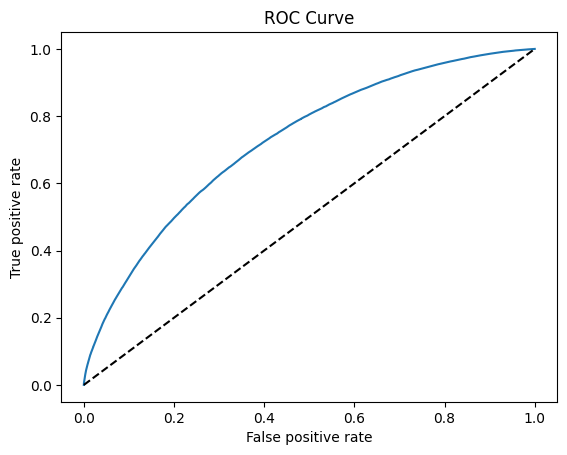

In [1384]:
# Graph ROC curve
fpr_lg_final, tpr_lg_final, thresholds_lg_final = roc_curve(lg_final_test_results['default'], lg_final_test_results['proba_default'])
plt.plot(fpr_lg_final, tpr_lg_final)
plt.plot(fpr_lg_final, fpr_lg_final, linestyle='--', color='k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.show()

In [1385]:
# Compute AUC
auc_lg_final = roc_auc_score(lg_final_test_results['default'], lg_final_test_results['proba_default'])
auc_lg_final

0.7255226565556845

### Develop scorecard

In [1389]:
data_feature_reeng.head()

,job_group,home_ownership,purpose,addr_state,int_rate,dti,fico_range_low
0,2,MORTGAGE,credit_card|debt_consolidation|house,state_group_3,3,1,1
1,1,MORTGAGE,small_business,state_group_3,2,2,2
2,3,MORTGAGE,home_improvement|vacation|other|major_purchase,state_group_2,2,1,1
3,1,MORTGAGE,home_improvement|vacation|other|major_purchase,state_group_3,3,3,1
4,1,RENT_OTHER,credit_card|debt_consolidation|house,state_group_2,2,1,1


In [1392]:
# First step is to add back the dummy variables that were removed to be used as the reference group.
# These dummy variables will be assigned a coefficient of 0.
# The reason for adding them back is to make the scorecard easier to understand.
ref_coef = pd.DataFrame({'Feature': ['job_group_1', 'loan_term_36', 'home_ownership_MORTGAGE', 'purpose_wedding', 'addr_state_state_group_1', 'int_rate_1', \
    'dti_1', 'fico_range_low_2', 'acc_open_past_24mths_group_1']})
ref_coef['Coefficient'] = 0

In [1416]:
scorecard_coef = pd.concat([ref_coef, summary_table_lg_final], ignore_index=True)

# Add coefficient of intercept
# In our case, since reference group represents borrowers with the least probability of default, intercept should correspond to the maximum credit score because 
# intercept represents a borrower when he belongs to the reference groups for all features.
scorecard_coef.loc[len(scorecard_coef.index)] = ['intercept', logistic_reg_final.intercept_[0]]
scorecard_coef.sort_values(by='Coefficient', inplace=True)
scorecard_coef.reset_index(drop=True, inplace=True)

In [1419]:
original_feature = []
for i in range(len(scorecard_coef)):
    if 'job_group' in scorecard_coef['Feature'][i]:
        original_feature.append('emp_title')
    elif 'loan_term' in scorecard_coef['Feature'][i]:
        original_feature.append('term')
    elif 'home_ownership' in scorecard_coef['Feature'][i]:
        original_feature.append('home_ownership')
    elif 'purpose' in scorecard_coef['Feature'][i]:
        original_feature.append('purpose') 
    elif 'addr_state' in scorecard_coef['Feature'][i]:
        original_feature.append('addr_state')    
    elif 'int_rate' in scorecard_coef['Feature'][i]:
        original_feature.append('int_rate') 
    elif 'dti' in scorecard_coef['Feature'][i]:
        original_feature.append('dti') 
    elif 'fico_range_low' in scorecard_coef['Feature'][i]:
        original_feature.append('fico_range_low') 
    elif 'acc_open_past_24mths' in scorecard_coef['Feature'][i]:
        original_feature.append('acc_open_past_24mths')
    else:
        original_feature.append(scorecard_coef['Feature'][i])

In [1430]:
# Next step is to calculate the sum of minimum coefficients and maximum coefficients of the original feature.
# In order to calculate this, we need to group data by original feature name and find the minimum and maximum coefficients.
scorecard_coef['Original_Feature'] = original_feature
scorecard_coef.head()

,Feature,Coefficient,Original_Feature
0,intercept,-4.194618,intercept
1,acc_open_past_24mths_group_1,0.000000,acc_open_past_24mths
2,fico_range_low_2,0.000000,fico_range_low
3,dti_1,0.000000,dti
4,int_rate_1,0.000000,int_rate


In [1426]:
max_sum_coef = scorecard_coef.groupby('Original_Feature')['Coefficient'].max().sum()
min_sum_coef = scorecard_coef.groupby('Original_Feature')['Coefficient'].min().sum()

In [1450]:
# Add a column Score indicating the score assigned to each category
# Score of a category is the category's coefficient * (max score - min score) / (min_sum_coef - max_sum_coef)
# max score is 850 and min score is 300, as FICO score.
scorecard_coef['Score'] = scorecard_coef['Coefficient']*(850-300)/(min_sum_coef-max_sum_coef)

# Change score of intercept to 850
scorecard_coef.loc[scorecard_coef['Feature']=='intercept', 'Score'] = 850

In [1465]:
# Round up scores to the nearest integer for easier calculation
scorecard_coef['Score_round'] = round(scorecard_coef['Score'])

# Replace scores for reference groups with 0
scorecard_coef.iloc[1:10, 4] = 0
scorecard_coef['Score_round'] = scorecard_coef['Score_round'].astype(int)

In [1466]:
# Verify the sum of minimum scores is 300, and the sum of maximum scores is 850
# The sum of minimum scores is 301, 1 point higher than 300. This is due to rounding. Since it's such a small difference, ignore it.
print(scorecard_coef.groupby('Original_Feature')['Score_round'].min().sum())
print(scorecard_coef.groupby('Original_Feature')['Score_round'].max().sum())

301
850


In [1470]:
final_scorecard = scorecard_coef[['Feature', 'Score_round']]
final_scorecard.rename(columns={'Feature':'category', 'Score_round':'score'}, inplace=True)
final_scorecard.sort_values(by='category')

,category,score
1,acc_open_past_24mths_group_1,0
10,acc_open_past_24mths_group_2,-10
17,acc_open_past_24mths_group_3,-27
9,addr_state_state_group_1,0
14,addr_state_state_group_2,-16
19,addr_state_state_group_3,-29
3,dti_1,0
11,dti_2,-11
18,dti_3,-28
24,dti_4,-38


### Cost benefit analysis

In [1518]:
data_cost_benefit = data[['funded_amnt', 'term', 'installment', 'total_pymnt', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'default']]

In [1533]:
# There are recoveries for some defaulted loans, meaning the total payment of these loans = total payment + recovery - collection cost
# Recovery and collection cost should be 0 for fully paid loans. Check it: Yes
print(data_cost_benefit[data_cost_benefit['default']==0]['recoveries'].unique())
print(data_cost_benefit[data_cost_benefit['default']==0]['collection_recovery_fee'].unique())

data_cost_benefit['total_pymnt_updated'] = data_cost_benefit['total_pymnt']+data_cost_benefit['recoveries']-data_cost_benefit['collection_recovery_fee']

[0.]
[0.]


In [1537]:
# Add a column indicating the amount of revenue or loss
# When a number is positive, revenue, otherwise, loss.
data_cost_benefit['revenue_loss'] = data_cost_benefit['total_pymnt_updated']-data_cost_benefit['funded_amnt']
data_cost_benefit.head()

,funded_amnt,term,installment,total_pymnt,total_rec_late_fee,recoveries,collection_recovery_fee,default,total_pymnt_updated,revenue_loss
0,3600.0,36 months,123.03,4421.723917,0.0,0.0,0.0,0,4421.723917,821.723917
1,24700.0,36 months,820.28,25679.660000,0.0,0.0,0.0,0,25679.660000,979.660000
2,20000.0,60 months,432.66,22705.924294,0.0,0.0,0.0,0,22705.924294,2705.924294
4,10400.0,60 months,289.91,11740.500000,0.0,0.0,0.0,0,11740.500000,1340.500000
5,11950.0,36 months,405.18,13708.948530,0.0,0.0,0.0,0,13708.948530,1758.948530


In [1611]:
# Calculate the average revenue from a non-defaulted loan
avg_revenue_non_default = round(data_cost_benefit[data_cost_benefit['default']==0]['revenue_loss'].sum()/data_cost_benefit[data_cost_benefit['default']==0].shape[0])
print(avg_revenue_non_default)

# Calculate the average loss from a defaulted loan
avg_loss_default = round(data_cost_benefit[data_cost_benefit['default']==1]['revenue_loss'].sum()/data_cost_benefit[data_cost_benefit['default']==1].shape[0])
print(avg_loss_default)

2327
-6258


#### Compare revenue made and charge-off rate using predictions from the final and the first logistic regression model

In [1612]:
# Final the optimal probability of default threshold that maximizes revenue for the final logistic regression model.
for i in np.linspace(0, 1, 11):
    lg_final_test_results['predicted_default'] = np.where(lg_final_test_results['proba_default']>=i, 1, 0)
    tn_final_logistic = lg_final_test_results[(lg_final_test_results['predicted_default']==0) & (lg_final_test_results['default']==0)].shape[0]
    fn_final_logistic = lg_final_test_results[(lg_final_test_results['predicted_default']==0) & (lg_final_test_results['default']==1)].shape[0]
    print('Revenue using probability of default threshold', round(i, 1), ': ${:,}'.format(tn_final_logistic*avg_revenue_non_default+fn_final_logistic*avg_loss_default))

Revenue using probability of default threshold 0.0 : $0
Revenue using probability of default threshold 0.1 : $128,381,174
Revenue using probability of default threshold 0.2 : $217,517,007
Revenue using probability of default threshold 0.3 : $230,621,182
Revenue using probability of default threshold 0.4 : $212,039,826
Revenue using probability of default threshold 0.5 : $190,941,773
Revenue using probability of default threshold 0.6 : $177,469,613
Revenue using probability of default threshold 0.7 : $171,082,422
Revenue using probability of default threshold 0.8 : $167,590,372
Revenue using probability of default threshold 0.9 : $165,992,030
Revenue using probability of default threshold 1.0 : $165,875,455


In [1613]:
# When threshold is 0.3, revenue is the highest. See if more granular thresholds improve revenue.
# Threshold of 0.28 maximizes revenue with the final logistic regression model.
for i in np.linspace(0.25, 0.35, 8):
    lg_final_test_results['predicted_default'] = np.where(lg_final_test_results['proba_default']>=i, 1, 0)
    tn_final_logistic = lg_final_test_results[(lg_final_test_results['predicted_default']==0) & (lg_final_test_results['default']==0)].shape[0]
    fn_final_logistic = lg_final_test_results[(lg_final_test_results['predicted_default']==0) & (lg_final_test_results['default']==1)].shape[0]
    print('Revenue using probability of default threshold', round(i, 2), ': ${:,}'.format(tn_final_logistic*avg_revenue_non_default+fn_final_logistic*avg_loss_default))

Revenue using probability of default threshold 0.25 : $230,694,569
Revenue using probability of default threshold 0.26 : $231,762,694
Revenue using probability of default threshold 0.28 : $232,585,446
Revenue using probability of default threshold 0.29 : $231,619,060
Revenue using probability of default threshold 0.31 : $229,688,349
Revenue using probability of default threshold 0.32 : $228,091,307
Revenue using probability of default threshold 0.34 : $225,782,816
Revenue using probability of default threshold 0.35 : $222,521,529


In [1618]:
# Final the optimal probability of default threshold that maximizes revenue for the first logistic regression model.
for i in np.linspace(0, 1, 11):
    logistic_reg_test_results['predicted_default'] = np.where(logistic_reg_test_results['proba_default']>=i, 1, 0)
    tn_first_logistic = logistic_reg_test_results[(logistic_reg_test_results['predicted_default']==0) & (logistic_reg_test_results['default']==0)].shape[0]
    fn_first_logistic = logistic_reg_test_results[(logistic_reg_test_results['predicted_default']==0) & (logistic_reg_test_results['default']==1)].shape[0]
    print('Revenue using probability of default threshold', round(i, 1), ': ${:,}'.format(tn_first_logistic*avg_revenue_non_default+fn_first_logistic*avg_loss_default))

Revenue using probability of default threshold 0.0 : $0
Revenue using probability of default threshold 0.1 : $31,549,857
Revenue using probability of default threshold 0.2 : $157,021,766
Revenue using probability of default threshold 0.3 : $178,779,787
Revenue using probability of default threshold 0.4 : $167,250,510
Revenue using probability of default threshold 0.5 : $165,877,217
Revenue using probability of default threshold 0.6 : $165,879,386
Revenue using probability of default threshold 0.7 : $165,875,455
Revenue using probability of default threshold 0.8 : $165,875,455
Revenue using probability of default threshold 0.9 : $165,875,455
Revenue using probability of default threshold 1.0 : $165,875,455


In [1615]:
# Threshold of 0.24 maximizes revenue with the first logistic regression model.
for i in np.linspace(0.2, 0.35, 8):
    logistic_reg_test_results['predicted_default'] = np.where(logistic_reg_test_results['proba_default']>=i, 1, 0)
    tn_first_logistic = logistic_reg_test_results[(logistic_reg_test_results['predicted_default']==0) & (logistic_reg_test_results['default']==0)].shape[0]
    fn_first_logistic = logistic_reg_test_results[(logistic_reg_test_results['predicted_default']==0) & (logistic_reg_test_results['default']==1)].shape[0]
    print('Revenue using probability of default threshold', round(i, 2), ': ${:,}'.format(tn_first_logistic*avg_revenue_non_default+fn_first_logistic*avg_loss_default))

Revenue using probability of default threshold 0.2 : $157,021,766
Revenue using probability of default threshold 0.22 : $178,522,592
Revenue using probability of default threshold 0.24 : $187,205,722
Revenue using probability of default threshold 0.26 : $185,941,063
Revenue using probability of default threshold 0.29 : $181,249,352
Revenue using probability of default threshold 0.31 : $177,358,576
Revenue using probability of default threshold 0.33 : $173,496,062
Revenue using probability of default threshold 0.35 : $171,020,807


In [1628]:
print('Incremental revenue from the final logistic regression model compared to the 1st: ${:,} ({:.0%})'.format(232585446-187205722, (232585446-187205722)/187205722))

Incremental revenue from the final logistic regression model compared to the 1st: $45,379,724 (24%)


In [1655]:
# Check confusion matrix for both models
lg_final_test_results['predicted_default'] = np.where(lg_final_test_results['proba_default']>=0.28, 1, 0)
pd.crosstab(lg_final_test_results['default'], lg_final_test_results['predicted_default'], rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,176084,39375
1,28295,25316


In [1630]:
logistic_reg_test_results['predicted_default'] = np.where(logistic_reg_test_results['proba_default']>=0.24, 1, 0)
pd.crosstab(logistic_reg_test_results['default'], logistic_reg_test_results['predicted_default'], rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,170086,45373
1,33368,20243


In [19]:
# Compare charge-off rate
print('Charge-off rate of the final logistic regression model: {:.1%}'.format(28295/(28295+176084)))
print('Charge-off rate of the first logistic regression model: {:.1%}'.format(33368/(33368+170086)))

Charge-off rate of the final logistic regression model: 13.8%
Charge-off rate of the first logistic regression model: 16.4%


In [18]:
# Calculate charge-off rate of baseline model
# (170086+45373)/2
# (33368+20243)/2
# (26806)/(107730+26806)
print('Charge-off rate of baseline model: {:.1%}'.format((26806)/(107730+26806)))

Charge-off rate of baseline model: 19.9%


In [20]:
(13.8-19.9)/19.9

-0.30653266331658285

#### Compare results to baseline
- Baseline is constructed by predicting the most frequent class in the training data.

In [1661]:
lg_final_test_results['baseline_prediction'] = y_lg_final_train.mode()[0]
pd.crosstab(lg_final_test_results['default'], lg_final_test_results['baseline_prediction'], rownames=['Actual'], colnames=['Baseline_prediction'])

Baseline_prediction,0
Actual,
0,215459
1,53611


In [1672]:
# Baseline revenue
baseline_revenue = 215459*avg_revenue_non_default+53611*avg_loss_default
print('Baseline revenue: ${:,}'.format(baseline_revenue))
print('Revenue of the final logistic regression model is higher than baseline revenue by ${:,} ({:.0%})'\
    .format(232585446-baseline_revenue, (232585446-baseline_revenue)/baseline_revenue))

Baseline revenue: $165,875,455
Revenue of the final logistic regression model is higher than baseline revenue by $66,709,991 (40%)


### KNN model with the same features as the final logistic regression model
- Compare performance of logistic regression with KNN
- Very time-consuming to use KNN for predicting default probability since the Euclidean distance needs to be calculated between each record in the testing set and each record in the training set, and we have more than one million records in the training set.

In [1678]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_lg_final_train, y_lg_final_train)
knn_predictions = knn.predict(X_lg_final_test)

In [1701]:
knn_default_proba = knn.predict_proba(X_lg_final_test)[:, 1]

In [1703]:
# Build a dataframe containing actual default and predicted default of KNN
knn_test_results = pd.DataFrame({'default':y_lg_final_test.values})
knn_test_results['predicted_default'] = knn_predictions
knn_test_results['proba_default'] = knn_default_proba

In [1705]:
# AUC
roc_auc_score(knn_test_results['default'], knn_test_results['proba_default'])

0.5602019968509406

In [1690]:
# Confusion matrix of KNN
pd.crosstab(knn_test_results['default'], knn_test_results['predicted_default'], rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1
Actual,,
0,172810,42649
1,36544,17067


### Decision tree model

In [1709]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_lg_final_train, y_lg_final_train)

DecisionTreeClassifier()